In [87]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt   
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams.update({"axes.grid" : True, "grid.color": "black", "grid.alpha":"0.25", "grid.linestyle": "--"})
plt.rcParams.update({'font.size': 14})
from HANKModel import HANKModelClass
from funktioner import *
import numba as nb  

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [88]:
import importlib, funktioner
importlib.reload(funktioner)

<module 'funktioner' from 'c:\\Users\\B307102\\Desktop\\priv\\SpecialeHANK\\Adv_macro_het_agents\\AdvMacroHet\\Speciale 2025\\BASE4\\funktioner.py'>

In [89]:
# --- use YOUR package-level exports (this works with your repo) ---
from GEModelTools import (
    simulate_hh_forwards_exo_transpose,    # OK in your version
    simulate_hh_forwards_endo_transpose    # OK in your version
)  # :contentReference[oaicite:2]{index=2}

In [90]:
model = HANKModelClass(name='baseline')
model.find_ss(do_print=True)
model._compute_jac_hh()
model.calc_MPC()
model.compute_jacs(skip_hh=False,skip_shocks=False)
model.find_IRFs(shocks=['eps_i'],do_print=False)


 Y =   1.0000
 r    =   0.0050
 A    =   1.2505
 pD   =   1.2505
Discrepancy in A =   0.00000000
Discrepancy in Y =   0.00000000
MPC = 0.36, iMPC[0,0] = 0.36
annual_MPC = 0.50


In [91]:
# Hetero-beliefs version (also 6 states)
model_het = HANKModelClass(name='hank_het6')
model_het.find_ss()
model_het._compute_jac_hh()
model_het.calc_MPC()
model_het.compute_jacs(do_print=False)

MPC = 0.36, iMPC[0,0] = 0.36
annual_MPC = 0.50


In [8]:
model_sticky = model.copy()

In [9]:
sticky_vars=['Z','ra']

In [10]:
E_list = [E_hybrid(model_het.par.T, lam, theta=0.95) for lam in [0.0,0.2,0.4,0.6,0.8,1.0]]
E_by_z = {'Z':E_list, 'ra':E_list}


In [11]:
import numpy as np

# --- your original homogeneous operator (unchanged) ---
def create_alt_M(M, E):
    T, m = M.shape
    assert T == m and E.shape == (T, T)
    M_beh = np.empty_like(M)
    for t in range(T):
        for s in range(T):
            summand = 0.0
            for tau in range(min(s, t) + 1):
                if tau > 0:
                    summand += (E[tau, s] - E[tau - 1, s]) * M[t - tau, s - tau]
                else:
                    summand += E[tau, s] * M[t - tau, s - tau]
            M_beh[t, s] = summand
    return M_beh

# --- EXACT sticky expectations (your function; unchanged) ---
def E_sticky_exp(theta, T=300):
    col = 1 - theta**(1 + np.arange(T))       # cumulative adoption by tau
    E = np.tile(col[:, np.newaxis], (1, T))
    E = np.triu(E, +1) + np.tril(np.ones((T, T)))  # ones at/after s
    return E

# --- NEW: per-z cumulative matrix from lambda_z (heterogeneity enters pre-s) ---
# Intuition: lam_z is the per-period adoption rate BEFORE s.
# Cumulative adoption up to lag tau: 1 - (1 - lam_z)^(tau+1).
# At/after s, agents fully see the realization (lower triangle = 1), just like sticky.
def E_from_lambda_cumulative(T, lam_z):
    """
    Per-z expectations matrix where pre-s entries are *cumulative sums* of geometric
    powers: ΔE[tau,s] = E[tau,s] - E[tau-1,s] = lam_z**(tau+1).
    Post-s (t >= s) entries are 1.

    Example for lam_z=0.2 and column s:
      [0.2, 0.2+0.2^2, 0.2+0.2^2+0.2^3, ...] above the diagonal,
      1 on and below the diagonal.
    """
    import numpy as np
    E = np.zeros((T, T))
    for s in range(T):
        # pre-s cumulative geometric sum
        for tau in range(s + 1):  # tau = s - t
            if lam_z == 1.0:
                E[tau, s] = tau + 1.0
            else:
                E[tau, s] = lam_z * (1.0 - lam_z**(tau + 1)) / (1.0 - lam_z)
        # on/after s: full information
        E[s:, s] = 1.0
    return E

def E_hybrid_cumulative(T, lam, theta_post=None):
    """
    Cumulative E for create_alt_M.

    Pre-s (t < s): ΔE[tau,s] = lam**(tau+1)  ⇒  E[tau,s] = sum_{k=1}^{tau+1} lam**k
    Post-s (t >= s):
        - if theta_post is None: full revelation ⇒ E[t,s] = 1
        - else: ΔE[s+k,s] = theta_post**k  ⇒  E[s+k,s] = sum_{j=0}^{k} theta_post**j
    """
    import numpy as np
    E = np.zeros((T, T))
    # pre-s cumulative
    for s in range(T):
        for tau in range(s + 1):
            if lam == 1.0:
                E[tau, s] = tau + 1.0
            else:
                E[tau, s] = lam * (1.0 - lam**(tau + 1)) / (1.0 - lam)

        # post-s cumulative
        if theta_post is None:
            E[s:, s] = 1.0
        else:
            run = 0.0
            for k in range(T - s):
                run += theta_post**k  # cumulative of post-shock arrivals
                E[s + k, s] = run
    return E


# --- weights & Markov helpers (unchanged logic) ---
def _z_weights_from_ss(model):
    D = model.ss.D                   # (Nfix, Nz, Na)
    w = np.sum(D, axis=(0, 2))       # (Nz,)
    total = np.sum(w)
    if not np.isfinite(total) or total <= 0:
        raise ValueError("Invalid steady-state mass; cannot compute z-weights.")
    return w / total

def _find_markov_P(model, Nz):
    for name in ['Pi','P','pi_z','Pz','Pi_z','PiZ','P_Z']:
        if hasattr(model.par, name):
            P = np.asarray(getattr(model.par, name))
            if P.ndim == 2 and P.shape == (Nz, Nz):
                if np.allclose(P.sum(axis=1), 1.0, atol=1e-10) and np.all(P >= -1e-12):
                    return P
    return None

def _markov_weight_history(w0, P, T):
    w_hist = np.zeros((T, w0.size))
    w = w0.copy()
    for t in range(T):
        w_hist[t] = w
        w = w @ P
    return w_hist

# build an effective cumulative matrix by (possibly) time-varying z-weights
def _create_E_eff_markov_weighted(E_list, w0, P, T):
    Nz = len(E_list)
    for iz, Ez in enumerate(E_list):
        Ez = np.asarray(Ez)
        if Ez.shape != (T, T):
            raise ValueError(f"E_list[{iz}] has shape {Ez.shape}, expected {(T,T)}")
    w_hist = _markov_weight_history(w0, P, T) if P is not None else None
    E_eff = np.zeros((T, T))
    for s in range(T):
        for tau in range(s + 1):        # only tau<=s is used by the transform
            w = w_hist[s - tau] if w_hist is not None else w0
            E_eff[tau, s] = sum(w[iz] * E_list[iz][tau, s] for iz in range(Nz))
    return E_eff

# --- single-entry solver: homogeneous (pass E) OR per-z (pass dict) ---
def solve_alt_exp(model, E_or_Ebyz, sticky_vars=('Z','ra')):
    T  = int(model.par.T)
    Nz = int(model.par.Nz)
    model_sticky = model.copy()

    hetero = isinstance(E_or_Ebyz, dict)
    if hetero:
        w0 = _z_weights_from_ss(model_sticky)
        P  = _find_markov_P(model_sticky, Nz)

    n_updated = 0
    for out_name in ['C_hh','A_hh']:
        for in_name in sticky_vars:
            key = (out_name, in_name)
            if key not in model_sticky.jac_hh:
                continue
            M = model_sticky.jac_hh[key].copy()  # (T,T)

            if hetero and (in_name in E_or_Ebyz):
                E_list = E_or_Ebyz[in_name]      # list of Nz cumulative matrices
                if len(E_list) != Nz:
                    raise ValueError(f"{in_name}: need {Nz} matrices, got {len(E_list)}")
                E_eff = _create_E_eff_markov_weighted(E_list, w0, P, T)
                J = create_alt_M(M, E_eff)
                model_sticky.jac_hh[key] = J
                n_updated += 1
            elif not hetero:
                E = np.asarray(E_or_Ebyz)        # single cumulative matrix
                if E.shape != (T, T):
                    raise ValueError(f"Homogeneous E must be {(T,T)}, got {E.shape}")
                J = create_alt_M(M, E)
                model_sticky.jac_hh[key] = J
                n_updated += 1
            # else: hetero but no matrix for this input -> leave unchanged

    mode_txt = "heterogeneous (per-z cumulative)" if hetero else "homogeneous"
    print(f"Applied alternative expectations for {tuple(sticky_vars)} — {mode_txt}. "
          f"Updated {n_updated} HH Jacobians.")
    model_sticky.compute_jacs(skip_hh=True, skip_shocks=False)
    model_sticky.find_IRFs(shocks=['eps_i'], do_print=False)
    return model_sticky


In [12]:
import numpy as np

def E_hybrid_cumulative_single(T, lam, theta_post=None):
    """
    Cumulative E for create_alt_M.

    Pre-s (t < s): ΔE[tau,s] = lam**(tau+1)  ⇒  E[tau,s] = sum_{k=1}^{tau+1} lam**k
    Post-s (t >= s):
        - if theta_post is None: full revelation ⇒ E[t,s] = 1
        - else: ΔE[s+k,s] = theta_post**k  ⇒  E[s+k,s] = sum_{j=0}^{k} theta_post**j
    """
    E = np.zeros((T, T))
    # pre-s cumulative
    for s in range(T):
        for tau in range(s + 1):
            if lam == 1.0:
                E[tau, s] = tau + 1.0
            else:
                E[tau, s] = lam * (1.0 - lam**(tau + 1)) / (1.0 - lam)
        # post-s cumulative
        if theta_post is None:
            E[s:, s] = 1.0
        else:
            run = 0.0
            for k in range(T - s):
                run += (theta_post ** k)
                E[s + k, s] = run
    return E

def build_E_by_z_from_lambda(T, lambda_by_z, inputs=('Z','ra'), theta_post=None):
    """
    Turn a lambda vector (length Nz) into the per-z expectation matrices dict:
      {'Z':[E_z0,...], 'ra':[E_z0,...], ...}

    theta_post can be:
      - None (full info after s),
      - a scalar (same post-shock decay for all z),
      - a vector of length Nz (different post-shock decay per z).
    """
    lambda_by_z = np.asarray(lambda_by_z, dtype=float)
    Nz = lambda_by_z.size

    # broadcast theta_post
    if theta_post is None or np.isscalar(theta_post):
        theta_vec = np.full(Nz, 1.0 if theta_post is None else float(theta_post))
        theta_vec[theta_post is None] = 1.0  # not used, just explicit
    else:
        theta_vec = np.asarray(theta_post, dtype=float)
        if theta_vec.size != Nz:
            raise ValueError(f"theta_post length {theta_vec.size} must equal Nz={Nz}")

    # build one E per z
    E_list = [E_hybrid_cumulative_single(T, lam=float(lambda_by_z[iz]),
                                         theta_post=None if theta_post is None else float(theta_vec[iz]))
              for iz in range(Nz)]

    # same set for every input you want to treat as expectation-driven
    return {i: [E.copy() for E in E_list] for i in inputs}


In [13]:
import numpy as np

def E_per_z_sticky_style(T, lam):
    """
    Pre-s: ΔE[tau,s] = lam**(tau+1)  (so E[tau,s] = sum_{k=1}^{tau+1} lam**k)
    Post-s: E[t,s] = 1  (full information at/after realization, like E_sticky_exp)
    """
    E = np.zeros((T, T))
    if lam == 1.0:
        pre = np.arange(1, T+1, dtype=float)
    else:
        tau = np.arange(T, dtype=float)
        pre = lam * (1.0 - lam**(tau + 1)) / (1.0 - lam)  # cumulative geometric sum
    for s in range(T):
        E[:s+1, s] = pre[:s+1]  # cumulative pre-s
        E[s:,   s] = 1.0        # full info post-s (match E_sticky)
    return E

def build_E_by_z_from_lambda_sticky_post(T, lambda_by_z, inputs=('Z','ra')):
    """
    Build per-z expectation matrices with sticky-style post-s (ones).
    """
    mats = [E_per_z_sticky_style(T, float(lam)) for lam in lambda_by_z]
    return {i: [M.copy() for M in mats] for i in inputs}


In [14]:
import numpy as np

# --- core: sanitize ONE cumulative E (T,T) ---
def _sanitize_cumulative_E_single(E):
    """
    Input E: cumulative expectations matrix (T,T) that may violate [0,1] / monotonicity.
    Output:   E_san of the same shape with:
              - for each column s: E_san[t,s] is nondecreasing in t, in [0,1], with E_san[s,s]=1
              - pre-entries t<s kept (clipped to [0,1])
    """
    E = np.asarray(E, dtype=float)
    T = E.shape[0]
    E_san = np.zeros_like(E)

    for s in range(T):
        col = E[:, s].copy()

        # 1) handle pre-announcement part (t < s)
        pre = np.clip(col[:s], 0.0, 1.0)  # keep and clip to [0,1]
        E_san[:s, s] = pre

        # 2) ensure diagonal is 1 (fully known at t=s)
        base = max(0.0, min(1.0, col[s])) if s < T else 1.0
        if base == 0.0:
            base = 1.0
        E_san[s, s] = 1.0

        # 3) incremental "news weights" for t >= s:
        #    raw increments ΔE_raw[t] = E[t,s] - E[t-1,s]; then clip negatives; renormalize to sum=1
        #    finally re-cumulate to enforce bounded monotone cumulative ≤ 1
        # construct raw increments on t>=s
        inc = np.zeros(T - s)
        inc[0] = 1.0                             # force E_san[s,s] = 1
        if s + 1 < T:
            raw = np.diff(col[s:s+1+(T-s-1)], prepend=col[s])  # zeros, but explicit
            # Better: compute from original (we already set inc[0]=1). For t>s:
            raw = col[s:(T)] - np.r_[col[s], col[s:(T-1)]]
            raw[0] = 1.0  # override to ensure diag=1
            # clip negatives
            raw = np.maximum(raw, 0.0)
            # if sum(raw) == 0, fall back to a point mass at t=s already (we set raw[0]=1)
            if raw.sum() == 0.0:
                inc[:] = 0.0
                inc[0] = 1.0
            else:
                # renormalize to sum 1
                inc = raw / raw.sum()
        # re-cumulate to get a proper bounded cumulative on t>=s
        post_cum = np.cumsum(inc)
        post_cum = np.clip(post_cum, 0.0, 1.0)

        # write back (ensuring t=s matches 1.0)
        E_san[s:, s] = post_cum

    # final clip for numerical safety
    np.clip(E_san, 0.0, 1.0, out=E_san)
    return E_san

# --- helpers to accept many shapes for per-z collections ---
def _ensure_TxT(E, T):
    E = np.asarray(E)
    if E.ndim != 2: raise ValueError(f"E must be 2D, got {E.shape}")
    if E.shape[0] < T or E.shape[1] < T: raise ValueError(f"E too small: {E.shape} < ({T},{T})")
    if E.shape != (T, T): E = E[:T, :T]
    return E

def _iter_perz(perz, Nz, T):
    """Yield per-z matrices from many input formats, returning a list of (T,T)."""
    out = []
    if isinstance(perz, dict):
        if len(perz) != Nz:
            raise ValueError(f"per-z dict has {len(perz)} entries but Nz={Nz}.")
        for k in perz.keys():
            out.append(_ensure_TxT(perz[k], T))
        return out
    arr = np.asarray(perz, dtype=object)
    if arr.ndim == 3:
        if arr.shape[0] == Nz:
            return [_ensure_TxT(arr[z], T) for z in range(Nz)]
        if arr.shape[-1] == Nz:
            return [_ensure_TxT(arr[:, :, z], T) for z in range(Nz)]
        raise ValueError(f"3D per-z has incompatible shape {arr.shape}.")
    if arr.ndim == 2:
        E = _ensure_TxT(arr, T)
        return [E for _ in range(Nz)]
    if arr.ndim == 1:
        # If you passed lambdas (length Nz), build bounded cumulative form <= 1
        if arr.size != Nz:
            raise ValueError(f"lambda vector length {arr.size} != Nz={Nz}.")
        mats = []
        for lam in arr:
            lam = float(lam)
            # bounded sticky-like cumulative for t>=s:
            # pre-announcement set to 0 here; change if you want leakage
            E = np.zeros((T, T))
            for s in range(T):
                E[s, s] = 1.0
                for t in range(s+1, T):
                    h = t - s
                    E[t, s] = 1.0 - (1.0 - lam) ** (h+1)
            mats.append(E)
        return mats
    raise ValueError(f"Unsupported per-z spec with shape {arr.shape}.")

# --- top-level: sanitize E_by_z in any of the forms we used earlier ---
def sanitize_E_by_z(E_by_z, T, Nz):
    """
    Accepts:
      - dict {'Z': perzZ, 'ra': perzR}, where perzZ/perzR can be dict/list/array of (T_full,T_full) or lambdas
      - OR a single per-z collection (applied to both channels upstream if you reuse)
    Returns a structure with the same top-level form, but with each per-z matrix sanitized to be a proper cumulative CDF.
    """
    # If it's the two-channel dict, sanitize each channel separately
    if isinstance(E_by_z, dict) and set(E_by_z.keys()) >= {'Z', 'ra'}:
        out = {}
        for key in ['Z', 'ra']:
            perz = _iter_perz(E_by_z[key], Nz, T)  # list of (T,T)
            out[key] = [ _sanitize_cumulative_E_single(Ez) for Ez in perz ]
        return out
    # Otherwise treat as a single per-z collection
    perz = _iter_perz(E_by_z, Nz, T)
    return [ _sanitize_cumulative_E_single(Ez) for Ez in perz ]


In [15]:
import numpy as np
from copy import deepcopy
import time

def _calc_jac_hh_direct_with_z(model, jac_hh, jac_hh_z, inputname, dx=1e-4, do_print=False, s_list=None):
    """
    Direct household Jacobian for a single input, extended with per-z Jacobians.
    
    Fills:
        jac_hh[(OUTPUT_hh, inputname)]   -> (T, T)
        jac_hh_z[(OUTPUT_hh, inputname)] -> (Nz, T, T)
    """

    par  = model.par
    ss   = model.ss
    path = model.path

    if s_list is None:
        s_list = list(range(par.T))

    if do_print:
        t0 = time.time()
        print(f'finding Jacobian wrt. {inputname:15s}:', end='')

    # a. allocate
    for outputname in model.outputs_hh:
        key = (f'{outputname.upper()}_hh', inputname)
        jac_hh[key]   = np.zeros((par.T, par.T))
        jac_hh_z[key] = np.zeros((par.Nz, par.T, par.T))

    # b. solve with shock in last period
    model._set_inputs_hh_all_ss()

    if inputname != 'ghost':
        shockarray = getattr(model.path, inputname)
        shockarray[-1, 0] += dx

    model.solve_hh_path()

    # c. baseline shocked path storage
    path_shock = deepcopy(model.path)

    # Precompute steady-state aggregates by z for each output
    base_agg = {}
    base_z   = {}
    for outputname in model.outputs_hh:
        pol_ss = ss.__dict__[outputname]  # shape (Nfix, Nz, Na)
        D_ss   = ss.D                     # shape (Nfix, Nz, Na)

        base_agg[outputname] = np.sum(pol_ss * D_ss)

        base_z_out = np.zeros(par.Nz)
        for i_z in range(par.Nz):
            base_z_out[i_z] = np.sum(pol_ss[:, i_z, :] * D_ss[:, i_z, :])
        base_z[outputname] = base_z_out

    # d. loop over s (time of shock)
    for s in s_list:

        if do_print:
            print(f' {s}', end='')

        # i. before shock: time to shock matters
        path.z_trans[:s+1]     = path_shock.z_trans[par.T-(s+1):]
        path.pol_indices[:s+1] = path_shock.pol_indices[par.T-(s+1):]
        path.pol_weights[:s+1] = path_shock.pol_weights[par.T-(s+1):]

        for outputname in model.outputs_hh:
            path.__dict__[outputname][:s+1] = path_shock.__dict__[outputname][par.T-(s+1):]

        # ii. after shock: solution is steady state
        path.pol_indices[s+1:] = ss.pol_indices
        path.pol_weights[s+1:] = ss.pol_weights
        path.z_trans[s+1:]     = ss.z_trans

        for outputname in model.outputs_hh:
            path.__dict__[outputname][s+1:] = ss.__dict__[outputname]

        # iii. simulate full path
        model.simulate_hh_path()

        # iv. compute Jacobians (aggregate + per z)
        for outputname in model.outputs_hh:

            key     = (f'{outputname.upper()}_hh', inputname)
            J_agg   = jac_hh[key]          # (T, T)
            J_z_out = jac_hh_z[key]        # (Nz, T, T)

            pol_ss = ss.__dict__[outputname]   # (Nfix, Nz, Na)
            D_ss   = ss.D                      # (Nfix, Nz, Na)

            for t in range(par.T):

                pol_t = path.__dict__[outputname][t]  # (Nfix, Nz, Na)
                D_t   = path.D[t]                     # (Nfix, Nz, Na)

                # aggregate
                shock_agg = np.sum(pol_t * D_t)
                J_agg[t, s] = (shock_agg - base_agg[outputname]) / dx

                # per-z
                for i_z in range(par.Nz):
                    shock_z = np.sum(pol_t[:, i_z, :] * D_t[:, i_z, :])
                    J_z_out[i_z, t, s] = (shock_z - base_z[outputname][i_z]) / dx

    if do_print:
        print(' done')


def compute_jac_hh_z(model, dx=1e-4, inputs_hh_all=None, do_print=False, s_list=None):
    """
    Compute household Jacobians per productivity state z using the *direct* method.

    After calling this, you get:
        model.jac_hh_z[(OUTPUT_hh, INPUT)]  -> array with shape (Nz, T, T)

    Returns:
        jac_hh_z (same dict as model.jac_hh_z)
    """

    if inputs_hh_all is None:
        inputs_hh_all = model.inputs_hh_all

    par = model.par

    jac_hh        = {}
    jac_hh_ghost  = {}
    jac_hh_z      = {}
    jac_hh_z_ghost = {}

    path_original = model.path
    model.path    = deepcopy(model.path)

    t0 = time.time()
    if do_print:
        print('computing per-z household Jacobians (direct method)...')

    # i. ghost run
    _calc_jac_hh_direct_with_z(model, jac_hh_ghost, jac_hh_z_ghost,
                               'ghost', dx=dx, do_print=do_print, s_list=s_list)

    # ii. each actual input
    for inputname in inputs_hh_all:
        _calc_jac_hh_direct_with_z(model, jac_hh, jac_hh_z,
                                   inputname, dx=dx, do_print=do_print, s_list=s_list)

    # iii. ghost-corrected result
    jac_hh_z_final = {}

    for outputname in model.outputs_hh:
        for inputname in model.inputs_hh_all:

            key       = (f'{outputname.upper()}_hh', inputname)
            key_ghost = (f'{outputname.upper()}_hh', 'ghost')

            if inputname not in inputs_hh_all:
                jac_hh_z_final[key] = np.zeros((par.Nz, par.T, par.T))
            else:
                jac_hh_z_final[key] = jac_hh_z[key] - jac_hh_z_ghost[key_ghost]

    model.jac_hh_z = jac_hh_z_final

    if do_print:
        elapsed = time.time() - t0
        print(f'per-z household Jacobians computed in {elapsed:5.2f} seconds')

    # reset path
    model.path = path_original

    return jac_hh_z_final


In [16]:
import numpy as np
from copy import deepcopy
import time

def _calc_jac_hh_direct_with_z(model, jac_hh, jac_hh_z, inputname, dx=1e-4, do_print=False, s_list=None):
    """
    Direct household Jacobian for a single input, extended with per-z Jacobians.

    Fills:
        jac_hh[(OUTPUT_hh, inputname)]   -> (T, T)
        jac_hh_z[(OUTPUT_hh, inputname)] -> (Nz, T, T)
    """

    par  = model.par
    ss   = model.ss
    path = model.path

    if s_list is None:
        s_list = list(range(par.T))

    t0 = time.time()
    if do_print:
        print(f'finding Jacobian wrt. {inputname:15s}:', end='')

    # a. allocate aggregate + per-z
    for outputname in model.outputs_hh:
        key = (f'{outputname.upper()}_hh', inputname)
        jac_hh[key]   = np.zeros((par.T, par.T))
        jac_hh_z[key] = np.zeros((par.Nz, par.T, par.T))

    # b. set baseline inputs (steady state)
    model._set_inputs_hh_all_ss()

    # if we are not in the ghost run, apply a tiny shock in last period
    if inputname != 'ghost':
        shockarray = getattr(model.path, inputname)
        shockarray[-1, 0] += dx

    # solve household problem along the shocked path
    model.solve_hh_path()

    # store full shocked path
    path_shock = deepcopy(model.path)

    # steady state policies & distribution
    base_agg = {}
    base_z   = {}
    for outputname in model.outputs_hh:
        pol_ss = ss.__dict__[outputname]   # (Nfix, Nz, Na)
        D_ss   = ss.D                      # (Nfix, Nz, Na)

        base_agg[outputname] = np.sum(pol_ss * D_ss)

        bz = np.zeros(par.Nz)
        for i_z in range(par.Nz):
            bz[i_z] = np.sum(pol_ss[:, i_z, :] * D_ss[:, i_z, :])
        base_z[outputname] = bz

    # c. loop over shock timing s
    for s in s_list:

        if do_print:
            print(f' {s}', end='')

        # i. before shock: time to shock matters
        path.z_trans[:s+1]     = path_shock.z_trans[par.T-(s+1):]
        path.pol_indices[:s+1] = path_shock.pol_indices[par.T-(s+1):]
        path.pol_weights[:s+1] = path_shock.pol_weights[par.T-(s+1):]

        for outputname in model.outputs_hh:
            path.__dict__[outputname][:s+1] = path_shock.__dict__[outputname][par.T-(s+1):]

        # ii. after shock: back to steady state
        path.pol_indices[s+1:] = ss.pol_indices
        path.pol_weights[s+1:] = ss.pol_weights
        path.z_trans[s+1:]     = ss.z_trans

        for outputname in model.outputs_hh:
            path.__dict__[outputname][s+1:] = ss.__dict__[outputname]

        # iii. simulate the full distribution path
        model.simulate_hh_path()

        # iv. compute Jacobians
        for outputname in model.outputs_hh:

            key     = (f'{outputname.upper()}_hh', inputname)
            J_agg   = jac_hh[key]        # (T, T)
            J_z_out = jac_hh_z[key]      # (Nz, T, T)

            for t in range(par.T):

                pol_t = path.__dict__[outputname][t]  # (Nfix, Nz, Na)
                D_t   = path.D[t]                     # (Nfix, Nz, Na)

                # aggregate value at t
                shock_agg = np.sum(pol_t * D_t)
                J_agg[t, s] = (shock_agg - base_agg[outputname]) / dx

                # per-z values at t
                for i_z in range(par.Nz):
                    shock_z = np.sum(pol_t[:, i_z, :] * D_t[:, i_z, :])
                    J_z_out[i_z, t, s] = (shock_z - base_z[outputname][i_z]) / dx

    if do_print:
        print(' done')


def compute_jac_hh_z(model, dx=1e-4, inputs_hh_all=None, do_print=False, s_list=None, overwrite_model_jac_hh=False):
    """
    Compute household Jacobians per productivity state z using the *direct* method.

    After calling this, you get:
        model.jac_hh_direct[(OUTPUT_hh, INPUT)]  -> (T, T)   [direct method]
        model.jac_hh_z[(OUTPUT_hh, INPUT)]       -> (Nz, T, T)

    If overwrite_model_jac_hh=True, model.jac_hh will also be replaced
    by the direct aggregate.
    """

    if inputs_hh_all is None:
        inputs_hh_all = model.inputs_hh_all

    par = model.par

    jac_hh         = {}
    jac_hh_ghost   = {}
    jac_hh_z       = {}
    jac_hh_z_ghost = {}

    path_original = model.path
    model.path    = deepcopy(model.path)

    t0 = time.time()
    if do_print:
        print('computing per-z household Jacobians (direct method)...')

    # i. ghost run
    _calc_jac_hh_direct_with_z(model, jac_hh_ghost, jac_hh_z_ghost,
                               'ghost', dx=dx, do_print=do_print, s_list=s_list)

    # ii. actual inputs
    for inputname in inputs_hh_all:
        _calc_jac_hh_direct_with_z(model, jac_hh, jac_hh_z,
                                   inputname, dx=dx, do_print=do_print, s_list=s_list)

    # iii. ghost-corrected aggregates and per-z
    jac_hh_direct = {}
    jac_hh_z_final = {}

    for outputname in model.outputs_hh:
        for inputname in model.inputs_hh_all:

            key       = (f'{outputname.upper()}_hh', inputname)
            key_ghost = (f'{outputname.upper()}_hh', 'ghost')

            if inputname not in inputs_hh_all:
                jac_hh_direct[key]   = np.zeros((par.T, par.T))
                jac_hh_z_final[key]  = np.zeros((par.Nz, par.T, par.T))
            else:
                jac_hh_direct[key]  = jac_hh[key]   - jac_hh_ghost[key_ghost]
                jac_hh_z_final[key] = jac_hh_z[key] - jac_hh_z_ghost[key_ghost]

    model.jac_hh_direct = jac_hh_direct   # direct aggregate
    model.jac_hh_z      = jac_hh_z_final  # per-z

    if overwrite_model_jac_hh:
        model.jac_hh = jac_hh_direct

    if do_print:
        elapsed = time.time() - t0
        print(f'per-z household Jacobians computed in {elapsed:5.2f} seconds')

    # reset path
    model.path = path_original

    return jac_hh_z_final


In [17]:
def replace_aggregate_with_sum_over_z(model, source='jac_hh_z', target='jac_hh'):
    """
    Replace model.<target> with the aggregate obtained by summing over z
    from model.<source>.

    Parameters
    ----------
    model : GEModel (or similar)
        The model that holds jac_hh and jac_hh_z.
    source : str
        Attribute name containing per-z Jacobians (default: 'jac_hh_z').
    target : str
        Attribute name where the aggregate should be stored (default: 'jac_hh').

    After running:
        model.jac_hh[(OUTPUT_hh, INPUT)]  <-- sum_z model.jac_hh_z[(OUTPUT, INPUT)]
    """

    jac_z = getattr(model, source)

    jac_new = {}

    for key, Jz in jac_z.items():
        # Jz has shape (Nz, T, T)
        Jagg = Jz.sum(axis=0)  # (T, T)
        jac_new[key] = Jagg

    setattr(model, target, jac_new)

    return jac_new


In [18]:
import numba as nb
import numpy as np

@nb.njit
def create_alt_M_test(M, E):
    """ Here, E is the expectation matrix, M is the FIRE Jacobian """
    T, m = M.shape
    assert T == m
    assert E.shape == (T, T)
    
    M_beh = np.empty_like(M)
    for t in range(T):
        for s in range(T):
            summand = 0
            for tau in range(min(s,t)+1):
                if tau > 0:
                    summand += (E[tau, s] - E[tau-1, s]) * M[t - tau, s - tau]
                else:
                    summand += E[tau, s] * M[t - tau, s - tau]
            M_beh[t, s] = summand
    return M_beh


In [19]:
import numpy as np
import numba as nb
from copy import deepcopy
import collections.abc as cabc


# ------------------------------------------------------------
# 1. Numba-accelerated expectation-transformation operator
#    (same structure as you already use)
# ------------------------------------------------------------

@nb.njit
def create_alt_M(M, E):
    """Transform FIRE Jacobian M using expectation matrix E."""
    T, m = M.shape
    assert T == m
    assert E.shape == (T, T)
    
    M_beh = np.empty_like(M)
    for t in range(T):
        for s in range(T):
            summand = 0.0
            upper = min(s, t)
            for tau in range(upper + 1):
                if tau > 0:
                    summand += (E[tau, s] - E[tau-1, s]) * M[t - tau, s - tau]
                else:
                    summand += E[tau, s] * M[t - tau, s - tau]
            M_beh[t, s] = summand
    return M_beh


# ------------------------------------------------------------
# 2. Helper: get E_z for one productivity state, given a container
#    that holds all z-states for ONE input (e.g. for 'Z' or 'ra').
# ------------------------------------------------------------

def _get_E_for_z(E_container, i_z):
    """
    Flexible accessor for E_z given i_z, where E_container holds the
    per-z expectation matrices for ONE input (e.g. for 'Z' or 'ra').

    Supports:
    - 2D array: same E for all z
    - 3D array: E_container[i_z, :, :]
    - list/tuple: E_container[i_z]
    - dict:
        * if int keys 0..Nz-1: use E_container[i_z]
        * else: use insertion-order and take the i_z'th key
    """

    # numpy array
    if isinstance(E_container, np.ndarray):
        if E_container.ndim == 2:
            # same E for all z
            return E_container
        elif E_container.ndim == 3:
            return E_container[i_z, :, :]
        else:
            raise ValueError("E_container ndarray must be 2D or 3D.")

    # list or tuple
    if isinstance(E_container, (list, tuple)):
        return E_container[i_z]

    # mapping / dict-like
    if isinstance(E_container, cabc.Mapping):
        # if integer key exists, use it directly
        if i_z in E_container:
            return E_container[i_z]

        # otherwise, fall back to 'i_z-th element in insertion order'
        keys = list(E_container.keys())
        if i_z >= len(keys):
            raise IndexError(
                f"i_z={i_z} but E_container has only {len(keys)} keys."
            )
        k = keys[i_z]
        return E_container[k]

    raise TypeError(
        "E_container must be ndarray, list, tuple or dict-like. "
        f"Got type {type(E_container)}."
    )


# ------------------------------------------------------------
# 3. Main helper: apply heterogeneous expectations by z
#    to per-z household Jacobians, and (optionally) recompute
#    aggregate jac_hh as sum_z of the transformed per-z jacobians.
# ------------------------------------------------------------

def apply_heterogeneous_expectations_by_z(
    model_fire,
    model_beliefs,
    E_by_z_sane,
    sticky_vars=('Z', 'ra'),
    outputs=('C_hh', 'A_hh'),
    overwrite_aggregate=True
):
    """
    Take FIRE per-z Jacobians from model_fire.jac_hh_z
    and transform them with heterogeneous expectations E_by_z_sane,
    writing the result into model_beliefs.jac_hh_z.

    Expected structure of E_by_z_sane:
        E_by_z_sane[input_name][i_z] -> (T,T) expectation matrix

    Example:
        E_by_z_sane['Z'][0].shape  == (T, T)
        E_by_z_sane['ra'][3].shape == (T, T)

    Parameters
    ----------
    model_fire : model with FIRE (rational) expectations
        Must already have model_fire.jac_hh_z[(OUTPUT_hh, INPUT)] with shape (Nz, T, T).
    model_beliefs : model that will hold the heterogeneous-beliefs Jacobians
        Typically a deepcopy(model_fire) or model_fire itself.
    E_by_z_sane : dict
        Outer keys: input names, e.g. 'Z', 'ra'.
        Values: containers (list/tuple/dict/ndarray) indexed by z-state.
    sticky_vars : iterable of str
        Inputs for which expectations are deformed (e.g. 'Z', 'ra').
    outputs : iterable of str
        Household outputs to transform (e.g. 'C_hh', 'A_hh').
    overwrite_aggregate : bool
        If True, sets model_beliefs.jac_hh to sum_z model_beliefs.jac_hh_z.

    Returns
    -------
    model_beliefs : same object, mutated in-place.
    """

    # 1. Check that FIRE per-z Jacobians exist
    if not hasattr(model_fire, 'jac_hh_z'):
        raise AttributeError(
            "model_fire.jac_hh_z not found. "
            "You need to run compute_jac_hh_z(model_fire, ...) first."
        )

    # 2. Start from FIRE per-z Jacobians
    #    (non-sticky inputs stay as FIRE)
    model_beliefs.jac_hh_z = {
        key: val.copy() for key, val in model_fire.jac_hh_z.items()
    }

    # 3. Apply heterogeneous expectations per z for sticky vars
    for o in outputs:
        for i in sticky_vars:

            key = (o, i)
            if key not in model_fire.jac_hh_z:
                continue  # skip if combination does not exist

            if i not in E_by_z_sane:
                raise KeyError(
                    f"E_by_z_sane has no entry for input '{i}'. "
                    f"Available keys: {list(E_by_z_sane.keys())}"
                )

            # container with the per-z expectations for this INPUT (e.g. 'Z')
            E_container = E_by_z_sane[i]

            J_fire_z = model_fire.jac_hh_z[key]  # shape (Nz, T, T)
            Nz, T, _ = J_fire_z.shape

            J_beh_z = np.empty_like(J_fire_z)

            for i_z in range(Nz):
                # Get expectations matrix for this z-type and this input
                E_z = _get_E_for_z(E_container, i_z)
                if E_z.shape != (T, T):
                    raise ValueError(
                        f"E_z for input '{i}', z-state {i_z} has shape {E_z.shape}, "
                        f"expected {(T, T)}."
                    )
                # Transform FIRE Jacobian for this z-type
                J_beh_z[i_z, :, :] = create_alt_M(J_fire_z[i_z].copy(), E_z)

            model_beliefs.jac_hh_z[key] = J_beh_z

    # 4. Optionally recompute aggregate jac_hh as sum over z
    if overwrite_aggregate:
        jac_new = {}
        for key, Jz in model_beliefs.jac_hh_z.items():
            # sum over z (axis 0) -> (T, T)
            jac_new[key] = Jz.sum(axis=0)
        model_beliefs.jac_hh = jac_new

    return model_beliefs


In [20]:
import numpy as np
from copy import deepcopy

def make_identity_E_by_z_like(E_by_z_sane):
    """
    Build an E_by_z_identity object that has the SAME structure as E_by_z_sane,
    but with FIRE expectations (identity / perfect foresight) for each z and input.
    """
    E_id = {}

    for inp, container in E_by_z_sane.items():
        # Example: container is something like {0: E0, 1: E1, ...} or a list
        # Peek at one matrix to get T
        if isinstance(container, dict):
            first_key = next(iter(container.keys()))
            T = container[first_key].shape[0]
        else:
            T = container[0].shape[0]

        # build identity expectation matrix
        E_base = np.eye(T)

        # replicate structure
        if isinstance(container, dict):
            E_id[inp] = {k: E_base.copy() for k in container.keys()}
        else:
            E_id[inp] = [E_base.copy() for _ in range(len(container))]

    return E_id


In [21]:
import numpy as np
from copy import deepcopy

def align_jac_hh_z_with_aggregate(model, keys=None, eps=1e-12, do_print=True):
    """
    Rescale per-z household Jacobians model.jac_hh_z so that for each key:
        sum_z jac_hh_z[key][z, :, :] == model.jac_hh[key]

    Uses model.jac_hh_direct[key] as the pre-alignment aggregate corresponding
    to the raw per-z jacobians.

    After running this, the identity-expectations pipeline should reproduce the
    original FIRE aggregate jac_hh and IRFs (up to small numerical noise).
    """

    if not hasattr(model, 'jac_hh_z'):
        raise AttributeError("model.jac_hh_z not found. Run compute_jac_hh_z(...) first.")
    if not hasattr(model, 'jac_hh_direct'):
        raise AttributeError("model.jac_hh_direct not found. compute_jac_hh_z must set it.")
    if not hasattr(model, 'jac_hh'):
        raise AttributeError("model.jac_hh (baseline aggregate) not found. Run compute_jacs(...) first on the original model before copying.")

    if keys is None:
        keys = list(model.jac_hh_z.keys())

    for key in keys:
        if key not in model.jac_hh_z:
            continue

        Jz      = model.jac_hh_z[key]          # (Nz, T, T) raw per-z (direct)
        J_dir   = model.jac_hh_direct.get(key, None)  # (T, T) direct aggregate
        J_base  = model.jac_hh.get(key, None)         # (T, T) baseline (fake-news) aggregate

        if J_dir is None or J_base is None:
            continue

        # scaling matrix S(t,s) such that:
        #   S(t,s) * J_dir(t,s) = J_base(t,s)
        # we then multiply ALL z-level entries by S(t,s),
        # so that sum_z Jz_scaled = J_base.
        S = np.ones_like(J_base)
        mask = np.abs(J_dir) > eps
        S[mask] = J_base[mask] / J_dir[mask]

        # apply scaling to each z
        model.jac_hh_z[key] = Jz * S[None, :, :]

        if do_print:
            J_new_agg = model.jac_hh_z[key].sum(axis=0)
            max_abs = np.max(np.abs(J_new_agg - J_base))
            print(f"{key}: alignment max|Σ_z Jz - J_base| = {max_abs:.3e}")

    return model


In [22]:
def E_sticky_exp(theta, T=300):
    col = 1 - theta**(1 + np.arange(T))
    E = np.tile(col[:, np.newaxis], (1, T))
    E = np.triu(E, +1) + np.tril(np.ones((T, T)))
    return E 

# Create expectations matrix 
E_sticky = E_sticky_exp(theta=0.935, T=model.par.T)

In [55]:
def build_E_by_z_sticky(theta_vec_Z, theta_vec_ra=None, T=300):
    """
    Build E_by_z_sane-like dict of sticky expectations matrices.

    theta_vec_Z  : array-like of length Nz with theta_z for Z expectations
    theta_vec_ra : array-like of length Nz with theta_z for ra expectations.
                   If None, reuse theta_vec_Z.
    T            : horizon

    Returns
    -------
    E_by_z : dict
        E_by_z['Z'][i_z]  -> (T,T) matrix for Z in state z
        E_by_z['ra'][i_z] -> (T,T) matrix for ra in state z
    """
    theta_vec_Z = np.asarray(theta_vec_Z)
    Nz = len(theta_vec_Z)

    if theta_vec_ra is None:
        theta_vec_ra = theta_vec_Z
    else:
        theta_vec_ra = np.asarray(theta_vec_ra)
        assert len(theta_vec_ra) == Nz

    E_by_z = {'Z': [], 'ra': []}

    for iz in range(Nz):
        thZ = theta_vec_Z[iz]
        thR = theta_vec_ra[iz]

        E_Z_z  = E_sticky_exp(thZ, T)
        E_ra_z = E_sticky_exp(thR, T)

        E_by_z['Z'].append(E_Z_z)
        E_by_z['ra'].append(E_ra_z)

    return E_by_z


In [58]:
# Example: 6 productivity states with different stickiness
theta_vec_Z  = np.array([0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95])
theta_vec_ra = np.array([0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95])

E_by_z_sticky = build_E_by_z_sticky(theta_vec_Z, theta_vec_ra, T=300)

# Now:
#   E_by_z_sticky['Z'][iz]  is your E_z for Z
#   E_by_z_sticky['ra'][iz] is your E_z for ra


In [23]:

# Modify Jacobian 
for o in ['C_hh', 'A_hh']:
        for i in sticky_vars:
            model_sticky.jac_hh[(o,i)] = create_alt_M(model.jac_hh[(o,i)].copy(), E_sticky)    
    
print(f'Alternative expectations applied w.r.t {sticky_vars}')

model_sticky.compute_jacs(skip_hh=True,skip_shocks=False)

model_sticky.find_IRFs(shocks=['eps_i'],do_print=False)

Alternative expectations applied w.r.t ['Z', 'ra']


In [52]:
lambda_by_z = [0.065, 0.065, 0.065, 0.065, 0.065, 0.065, 0.065, 0.065, 0.065, 0.065]
E_by_z = build_E_by_z_from_lambda_sticky_post(model.par.T, lambda_by_z, inputs=('Z','ra'))

In [ ]:
lambda_by_z = [0.0, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]
E_by_z = build_E_by_z_from_lambda_sticky_post(model.par.T, lambda_by_z, inputs=('Z','ra'))

In [50]:
# Suppose your model_het has par.T, par.Nz
T = int(model_het.par.T)
Nz = int(model_het.par.Nz)

E_by_z_sane = sanitize_E_by_z(E_by_z, T=300, Nz=Nz)

In [60]:
theta = 0.935
theta_vec_Z  = [theta]*Nz
theta_vec_ra = [theta]*Nz

E_by_z_sticky = build_E_by_z_sticky(theta_vec_Z, theta_vec_ra, T=300)
E_scalar      = E_sticky_exp(theta, T=300)


In [100]:
import numpy as np

def show_E_by_z(E_by_z, preview=6, max_items=6):
    # Handles dict -> (list/dict/array), or a single matrix/array
    print("E_by_z type:", type(E_by_z))
    if hasattr(E_by_z, "items"):
        print("keys:", list(E_by_z.keys()))
        for key, mats in E_by_z.items():
            print(f"\nE_by_z['{key}']:")
            # normalize to iterable of matrices
            if isinstance(mats, dict):
                items = list(mats.items())
            else:
                try:
                    items = list(enumerate(mats))
                except TypeError:
                    items = [(0, mats)]
            for j, (idx, M) in enumerate(items):
                A = np.asarray(M)
                print(f"  [{idx}] shape={A.shape}, dtype={A.dtype}", end="")
                if A.ndim == 2:
                    finite = np.isfinite(A).all()
                    print(f", finite={finite}")
                    r = min(preview, A.shape[0]); c = min(preview, A.shape[1])
                    print(A[:r, :c])
                else:
                    print("")
                if j+1 >= max_items:
                    print("  ... (truncated)")
                    break
    else:
        A = np.asarray(E_by_z)
        print("Single value shape:", A.shape, "dtype:", A.dtype)
        if A.ndim == 2:
            r = min(preview, A.shape[0]); c = min(preview, A.shape[1])
            print(A[:r, :c])

# Usage
show_E_by_z(E_by_z_sticky, preview=6, max_items=6)

E_by_z type: <class 'dict'>
keys: ['Z', 'ra']

E_by_z['Z']:
  [0] shape=(300, 300), dtype=float64, finite=True
[[1. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0.]
 [1. 1. 1. 1. 0. 0.]
 [1. 1. 1. 1. 1. 0.]
 [1. 1. 1. 1. 1. 1.]]
  [1] shape=(300, 300), dtype=float64, finite=True
[[1.      0.1     0.1     0.1     0.1     0.1    ]
 [1.      1.      0.19    0.19    0.19    0.19   ]
 [1.      1.      1.      0.271   0.271   0.271  ]
 [1.      1.      1.      1.      0.3439  0.3439 ]
 [1.      1.      1.      1.      1.      0.40951]
 [1.      1.      1.      1.      1.      1.     ]]
  [2] shape=(300, 300), dtype=float64, finite=True
[[1.      0.2     0.2     0.2     0.2     0.2    ]
 [1.      1.      0.36    0.36    0.36    0.36   ]
 [1.      1.      1.      0.488   0.488   0.488  ]
 [1.      1.      1.      1.      0.5904  0.5904 ]
 [1.      1.      1.      1.      1.      0.67232]
 [1.      1.      1.      1.      1.      1.     ]]
  [3] shape=(300, 300), dtype=float64, finite=

In [99]:
theta_vec_Z  = [1.0, 0.9, 0.8, 0.7, 0.6, 0.5]
theta_vec_ra = [1.0, 0.9, 0.8, 0.7, 0.6, 0.5]
E_by_z_sticky = build_E_by_z_sticky(theta_vec_Z, T=T)
E_scalar = E_sticky_exp(0.935, T=T)


In [45]:
print(E_sticky)

[[1.         0.065      0.065      ... 0.065      0.065      0.065     ]
 [1.         1.         0.125775   ... 0.125775   0.125775   0.125775  ]
 [1.         1.         1.         ... 0.18259962 0.18259962 0.18259962]
 ...
 [1.         1.         1.         ... 1.         1.         1.        ]
 [1.         1.         1.         ... 1.         1.         1.        ]
 [1.         1.         1.         ... 1.         1.         1.        ]]


In [50]:
# Your working FIRE model, where goods-market clears nicely
# (you already have this)
model.compute_jacs(do_print=False)             # fake-news HH jacobians
model.find_IRFs(shocks=['eps_i'], do_print=False)


In [51]:
# Fresh copy of the FIRE model
model_het = deepcopy(model)

# Compute per-z HH Jacobians (direct method), WITHOUT overwriting model_het.jac_hh
compute_jac_hh_z(model_het, dx=1e-4, do_print=False)  # creates jac_hh_direct, jac_hh_z


{('A_hh',
  'Z'): array([[[ 1.17247383e-03, -3.19358655e-04, -2.23645818e-04, ...,
          -4.77048956e-14, -4.77048956e-14, -3.90312782e-14],
         [ 1.10304351e-03,  9.81345844e-04, -5.08376805e-04, ...,
          -1.51788304e-13, -1.43114687e-13, -1.38777878e-13],
         [ 1.06917736e-03,  9.66018301e-04,  8.43181563e-04, ...,
          -3.42607887e-13, -3.25260652e-13, -3.07913417e-13],
         ...,
         [ 7.38955338e-09,  7.44985670e-09,  7.52392940e-09, ...,
          -2.47418539e-04, -1.71180044e-03, -1.52846877e-03],
         [ 7.06496493e-09,  7.12261413e-09,  7.19343422e-09, ...,
          -1.45958170e-04, -2.47418539e-04, -1.71180044e-03],
         [ 6.75462724e-09,  6.80975241e-09,  6.87745434e-09, ...,
          -6.38456566e-05, -1.45958170e-04, -2.47418539e-04]],
 
        [[ 1.69653086e-02, -4.05265438e-03, -2.85386859e-03, ...,
          -1.94289029e-12, -1.87350135e-12, -1.73472348e-12],
         [ 1.58513762e-02,  1.46544271e-02, -6.31725136e-03, ...,
    

In [52]:
# Make sure that sum_z jac_hh_z == original model_het.jac_hh (fake-news)
align_jac_hh_z_with_aggregate(model_het, do_print=True)


('A_hh', 'Z'): alignment max|Σ_z Jz - J_base| = 7.507e-12
('A_hh', 'chi'): alignment max|Σ_z Jz - J_base| = 7.450e-12
('A_hh', 'ra'): alignment max|Σ_z Jz - J_base| = 7.583e-12
('C_hh', 'Z'): alignment max|Σ_z Jz - J_base| = 5.915e-12
('C_hh', 'chi'): alignment max|Σ_z Jz - J_base| = 6.141e-12
('C_hh', 'ra'): alignment max|Σ_z Jz - J_base| = 5.984e-12


In [53]:
# Build identity expectations with same structure as E_by_z_sane
E_by_z_identity = make_identity_E_by_z_like(E_by_z_sane)

model_id = deepcopy(model_het)  # copy aligned per-z + baseline aggregates

# Apply "hetero" transformation with identity E (should change nothing)
apply_heterogeneous_expectations_by_z(
    model_fire    = model_id,
    model_beliefs = model_id,
    E_by_z_sane   = E_by_z_identity,
    sticky_vars   = ('Z','ra'),
    outputs       = ('C_hh','A_hh'),
    overwrite_aggregate = True
)

# Rebuild GE Jacobians with the HH block we just set
model_id.compute_jacs(skip_hh=True, skip_shocks=False, do_print=False)
model_id.find_IRFs(shocks=['eps_i'], do_print=False)

# Compare IRFs and GM residuals to original FIRE
T_test = 40
gm_fire = model.IRF['Y'][:T_test]   - model.IRF['C_hh'][:T_test]
gm_id   = model_id.IRF['Y'][:T_test] - model_id.IRF['C_hh'][:T_test]

print("Max |Y - C_hh| (FIRE original)   :", float(np.max(np.abs(gm_fire))))
print("Max |Y - C_hh| (identity aligned):", float(np.max(np.abs(gm_id))))

for var in ['Y','C_hh','Z','ra']:
    if var in model.IRF and var in model_id.IRF:
        diff = model_id.IRF[var][:T_test] - model.IRF[var][:T_test]
        print(f"{var}: max|Δ| = {float(np.max(np.abs(diff))):.3e}")


Max |Y - C_hh| (FIRE original)   : 6.693947266845149e-07
Max |Y - C_hh| (identity aligned): 3.625305361669266e-07
Y: max|Δ| = 6.775e-03
C_hh: max|Δ| = 6.775e-03
Z: max|Δ| = 6.733e-03
ra: max|Δ| = 1.215e-02


In [54]:
# Start from aligned per-z + baseline aggregate
model_het = deepcopy(model_het)  # or reuse directly if you prefer

apply_heterogeneous_expectations_by_z(
    model_fire    = model_het,
    model_beliefs = model_het,
    E_by_z_sane   = E_by_z_sane,    # your actual heterogeneous E matrices
    sticky_vars   = ('Z','ra'),
    outputs       = ('C_hh','A_hh'),
    overwrite_aggregate = True
)

model_het.compute_jacs(skip_hh=True, skip_shocks=False, do_print=False)
model_het.find_IRFs(shocks=['eps_i'], do_print=False)

# Now check goods-market:
gm_het = model_het.IRF['Y'][:T_test] - model_het.IRF['C_hh'][:T_test]
print("Max |Y - C_hh| (HET beliefs) :", float(np.max(np.abs(gm_het))))


Max |Y - C_hh| (HET beliefs) : 0.00015968317411647046


In [26]:
import numpy as np
from copy import deepcopy

# ------------------------------------------------------
# 1. Align per-z Jacobians with baseline aggregate
# ------------------------------------------------------

def align_jac_hh_z_with_aggregate(model, keys=None, eps=1e-12, do_print=True):
    """
    Rescale per-z household Jacobians model.jac_hh_z so that for each key:
        sum_z jac_hh_z[key][z, :, :] == model.jac_hh[key]

    Uses model.jac_hh_direct[key] as the aggregate corresponding to the
    raw per-z jacobians (both come from compute_jac_hh_z).

    After running this, the per-z decomposition is consistent with the
    baseline aggregate jac_hh.

    Assumes the model has:
        - model.jac_hh          (baseline FIRE / fake-news aggregate)
        - model.jac_hh_direct   (direct aggregate from compute_jac_hh_z)
        - model.jac_hh_z        (per-z direct jacobians)
    """

    if not hasattr(model, 'jac_hh_z'):
        raise AttributeError("model.jac_hh_z not found. Run compute_jac_hh_z(...) first.")
    if not hasattr(model, 'jac_hh_direct'):
        raise AttributeError("model.jac_hh_direct not found. compute_jac_hh_z must set it.")
    if not hasattr(model, 'jac_hh'):
        raise AttributeError("model.jac_hh (baseline aggregate) not found. "
                             "Run model.compute_jacs(...) on the original FIRE model before copying.")

    if keys is None:
        keys = list(model.jac_hh_z.keys())

    for key in keys:
        if key not in model.jac_hh_z:
            continue

        Jz     = model.jac_hh_z[key]                 # (Nz, T, T) raw per-z (direct)
        J_dir  = model.jac_hh_direct.get(key, None)  # (T, T) direct aggregate
        J_base = model.jac_hh.get(key, None)         # (T, T) baseline (fake-news) aggregate

        if J_dir is None or J_base is None:
            continue

        # scaling matrix S(t,s) such that:
        #   S(t,s) * J_dir(t,s) = J_base(t,s)
        S = np.ones_like(J_base)
        mask = np.abs(J_dir) > eps
        S[mask] = J_base[mask] / J_dir[mask]

        # apply scaling to each z-level slice
        model.jac_hh_z[key] = Jz * S[None, :, :]

        if do_print:
            J_new_agg = model.jac_hh_z[key].sum(axis=0)
            max_abs = np.max(np.abs(J_new_agg - J_base))
            print(f"{key}: alignment max|Σ_z Jz - J_base| = {max_abs:.3e}")

    return model


# ------------------------------------------------------
# 2. Diagnostics: goods-market residual and IRF comparison
# ------------------------------------------------------

def goods_market_residual(model, T=40, var_Y='Y', var_C='C_hh'):
    """Max |Y - C_hh| over first T periods."""
    Y = model.IRF[var_Y][:T]
    C = model.IRF[var_C][:T]
    return float(np.max(np.abs(Y - C)))

def compare_irfs(model_a, model_b, vars=('Y','C_hh','Z','ra'), T=40, label_a='A', label_b='B'):
    """Print max |Δ| for selected variables between two models."""
    print(f"\nIRF differences: {label_a} vs {label_b}")
    for v in vars:
        if v in model_a.IRF and v in model_b.IRF:
            diff = model_b.IRF[v][:T] - model_a.IRF[v][:T]
            print(f"  {v}: max|Δ| = {float(np.max(np.abs(diff))):.3e}")
        else:
            print(f"  {v}: (missing in one model)")


# ------------------------------------------------------
# 3. Optional: aggregate sticky expectations helper
# ------------------------------------------------------

def apply_aggregate_sticky_expectations(model_fire, E, sticky_vars=('Z','ra'), outputs=('C_hh','A_hh')):
    """
    Build a 'sticky expectations' model at the AGGREGATE level using create_alt_M
    directly on model_fire.jac_hh.

    E is the expectation matrix used in your standard sticky case (shape (T,T)).
    """
    model_sticky = deepcopy(model_fire)

    for o in outputs:
        for i in sticky_vars:
            key = (o, i)
            if key not in model_fire.jac_hh:
                continue
            J_fire = model_fire.jac_hh[key]
            J_sticky = create_alt_M(J_fire.copy(), E)
            model_sticky.jac_hh[key] = J_sticky

    # rebuild GE jacobians, but keep HH block
    model_sticky.compute_jacs(skip_hh=True, skip_shocks=False, do_print=False)
    return model_sticky


# ------------------------------------------------------
# 4. Full pipeline with intermediate diagnostics
# ------------------------------------------------------

def run_full_beliefs_diagnostics(model, E, E_by_z_sane,
                                 sticky_vars=('Z','ra'),
                                 outputs=('C_hh','A_hh'),
                                 T_test=40, dx=1e-4):
    """
    Run a multi-stage pipeline and print diagnostics at each step:

    Stage 0: Baseline FIRE
    Stage 1: Aggregate sticky expectations (create_alt_M on model.jac_hh)
    Stage 2: Per-z decomposition + alignment (no expectations modification)
    Stage 3: Heterogeneous expectations by z (E_by_z_sane)
    """

    print("========== STAGE 0: BASELINE FIRE ==========")
    # assume model already has jac_hh and IRFs (but ensure)
    model.compute_jacs(do_print=False)
    model.find_IRFs(shocks=['eps_i'], do_print=False)
    gm_fire = goods_market_residual(model, T=T_test)
    print(f"Max |Y - C_hh| (FIRE) = {gm_fire:.6e}")

    # --------------------------------------------------
    print("\n========== STAGE 1: AGGREGATE STICKY (create_alt_M) ==========")
    model_sticky = apply_aggregate_sticky_expectations(
        model_fire = model,
        E          = E,
        sticky_vars= sticky_vars,
        outputs    = outputs
    )
    model_sticky.find_IRFs(shocks=['eps_i'], do_print=False)
    gm_sticky = goods_market_residual(model_sticky, T=T_test)
    print(f"Max |Y - C_hh| (agg sticky) = {gm_sticky:.6e}")
    compare_irfs(model, model_sticky, T=T_test, label_a='FIRE', label_b='AGG-STICKY')

    # --------------------------------------------------
    print("\n========== STAGE 2: PER-z DECOMP + ALIGNMENT (no beliefs change) ==========")
    model_z = deepcopy(model)   # start from FIRE
    # compute per-z HH jacobians (direct)
    compute_jac_hh_z(model_z, dx=dx, do_print=False)
    # align per-z to baseline aggregate (fake-news)
    align_jac_hh_z_with_aggregate(model_z, do_print=True)
    # rebuild GE jacobians with aligned HH block
    model_z.compute_jacs(skip_hh=True, skip_shocks=False, do_print=False)
    model_z.find_IRFs(shocks=['eps_i'], do_print=False)

    gm_z = goods_market_residual(model_z, T=T_test)
    print(f"Max |Y - C_hh| (per-z aligned) = {gm_z:.6e}")
    compare_irfs(model, model_z, T=T_test, label_a='FIRE', label_b='PER-z-ALIGNED')

    # --------------------------------------------------
    print("\n========== STAGE 3: HETEROGENEOUS BELIEFS BY z (create_alt_M + E_by_z_sane) ==========")
    model_het = deepcopy(model_z)  # start from aligned per-z + baseline aggregate

    # apply heterogeneous expectations by z using your existing helper
    apply_heterogeneous_expectations_by_z(
        model_fire    = model_het,
        model_beliefs = model_het,
        E_by_z_sane   = E_by_z_sane,
        sticky_vars   = sticky_vars,
        outputs       = outputs,
        overwrite_aggregate = True
    )

    model_het.compute_jacs(skip_hh=True, skip_shocks=False, do_print=False)
    model_het.find_IRFs(shocks=['eps_i'], do_print=False)

    gm_het = goods_market_residual(model_het, T=T_test)
    print(f"Max |Y - C_hh| (HET by z) = {gm_het:.6e}")
    compare_irfs(model,      model_het, T=T_test, label_a='FIRE',       label_b='HET-z')
    compare_irfs(model_z,    model_het, T=T_test, label_a='PER-z-AL',   label_b='HET-z')
    compare_irfs(model_sticky, model_het, T=T_test, label_a='AGG-STICKY', label_b='HET-z')

    return {
        'model_fire':   model,
        'model_sticky': model_sticky,
        'model_z':      model_z,
        'model_het':    model_het
    }


In [27]:
results = run_full_beliefs_diagnostics(
    model        = model,          # your baseline FIRE model
    E            = E_sticky,              # your standard sticky expectations matrix (T,T)
    E_by_z_sane  = E_by_z_sane,    # your dict {'Z': [...], 'ra': [...]}
    sticky_vars  = ('Z','ra'),
    outputs      = ('C_hh','A_hh'),
    T_test       = 40,
    dx           = 1e-4
)


========== STAGE 0: BASELINE FIRE ==========
Max |Y - C_hh| (FIRE) = 6.754010e-07

========== STAGE 1: AGGREGATE STICKY (create_alt_M) ==========
Max |Y - C_hh| (agg sticky) = 9.061666e-08

IRF differences: FIRE vs AGG-STICKY
  Y: max|Δ| = 6.262e-03
  C_hh: max|Δ| = 6.262e-03
  Z: max|Δ| = 6.223e-03
  ra: max|Δ| = 7.385e-03

========== STAGE 2: PER-z DECOMP + ALIGNMENT (no beliefs change) ==========
('A_hh', 'Z'): alignment max|Σ_z Jz - J_base| = 8.253e-12
('A_hh', 'chi'): alignment max|Σ_z Jz - J_base| = 7.337e-12
('A_hh', 'ra'): alignment max|Σ_z Jz - J_base| = 8.134e-12
('C_hh', 'Z'): alignment max|Σ_z Jz - J_base| = 5.753e-12
('C_hh', 'chi'): alignment max|Σ_z Jz - J_base| = 5.066e-12
('C_hh', 'ra'): alignment max|Σ_z Jz - J_base| = 5.559e-12
Max |Y - C_hh| (per-z aligned) = 6.754010e-07

IRF differences: FIRE vs PER-z-ALIGNED
  Y: max|Δ| = 0.000e+00
  C_hh: max|Δ| = 0.000e+00
  Z: max|Δ| = 0.000e+00
  ra: max|Δ| = 0.000e+00

========== STAGE 3: HETEROGENEOUS BELIEFS BY z (create_a

In [ ]:
jac_hh_z = compute_jac_hh_z(model_het, dx=1e-4, do_print=True)

# aggregate from direct method:
J_agg_direct = model_het.jac_hh_direct[('C_hh', 'Z')]

# sum of per-z:
J_from_z = model_het.jac_hh_z[('C_hh', 'Z')].sum(axis=0)

np.allclose(J_agg_direct, J_from_z, rtol=1e-6, atol=1e-8)



In [ ]:
compute_jac_hh_z(model_het, dx=1e-4, do_print=True)
# now:
#   model_het.jac_hh_direct[(o,i)]  -> (T,T) (direct agg)
#   model_het.jac_hh_z[(o,i)]       -> (Nz,T,T)


In [ ]:
# on model_het
compute_jac_hh_z(model_het, dx=1e-5, do_print=True)
apply_heterogeneous_expectations_by_z(
    model_fire    = model_het,
    model_beliefs = model_het,
    E_by_z_sane   = E_by_z_sane,
    sticky_vars   = ('Z','ra'),
    outputs       = ('C_hh','A_hh'),
    overwrite_aggregate = True
)
model_het.compute_jacs(skip_hh=True, skip_shocks=False, do_print=False)
model_het.find_IRFs(shocks=['eps_i'], do_print=False)


In [ ]:
# We do NOT want to recompute HH Jacobians here, so we skip_hh=True.
model_het.compute_jacs(skip_hh=True, skip_shocks=False, do_print=False)


In [ ]:
model_het.find_IRFs(shocks=['eps_i'], do_print=False)

In [ ]:
# 1) Check that aggregate Jacobians used in GE indeed equal the sum over z:
for o in ['C_hh','A_hh']:
    for i in ['Z','ra']:
        key = (o, i)
        J_agg_from_z = model_het.jac_hh_z[key].sum(axis=0)
        J_agg_used   = model_het.jac_hh[key]
        print(key, np.allclose(J_agg_from_z, J_agg_used, rtol=1e-6, atol=1e-8))


In [ ]:
# 2) Goods market check on IRFs for a given shock (e.g. eps_i)
T_test = 40
gm_res_het = model_het.IRF['Y'][:T_test] - model_het.IRF['C_hh'][:T_test]
gm_res_fire = model.IRF['Y'][:T_test] - model.IRF['C_hh'][:T_test]

print("Max goods-market residual FIRE: ", np.max(np.abs(gm_res_fire)))
print("Max goods-market residual HET:  ", np.max(np.abs(gm_res_het)))


In [ ]:
model_het.jac_hh_original = model_het.jac_hh.copy()
replace_aggregate_with_sum_over_z(model_het)


In [ ]:
import numpy as np

def check_hh_jacobian_consistency(model_fire, model_het,
                                  outputs=('C_hh','A_hh'),
                                  inputs=('Z','ra'),
                                  rtol=1e-6, atol=1e-8):
    """
    1) Check that for BOTH models, aggregate hh Jacobians equal sum over z.
    2) Compare FIRE vs HET aggregate Jacobians.
    """

    print("=== 1. Aggregate vs sum over z (FIRE model) ===")
    for o in outputs:
        for i in inputs:
            key = (o,i)
            if not hasattr(model_fire, 'jac_hh_z') or key not in model_fire.jac_hh_z:
                print(f"[SKIP FIRE] {key} not in jac_hh_z")
                continue
            J_z = model_fire.jac_hh_z[key]         # (Nz,T,T)
            J_agg = model_fire.jac_hh[key]         # (T,T) (FIRE aggregate)
            ok = np.allclose(J_agg, J_z.sum(axis=0), rtol=rtol, atol=atol)
            print(f"FIRE {key}: agg == sum_z? {ok}")

    print("\n=== 2. Aggregate vs sum over z (HET model) ===")
    for o in outputs:
        for i in inputs:
            key = (o,i)
            if not hasattr(model_het, 'jac_hh_z') or key not in model_het.jac_hh_z:
                print(f"[SKIP HET] {key} not in jac_hh_z")
                continue
            J_z = model_het.jac_hh_z[key]
            J_agg = model_het.jac_hh[key]
            ok = np.allclose(J_agg, J_z.sum(axis=0), rtol=rtol, atol=atol)
            max_abs = np.max(np.abs(J_agg - J_z.sum(axis=0)))
            print(f"HET  {key}: agg == sum_z? {ok}, max|Δ|={max_abs:.3e}")

    print("\n=== 3. FIRE vs HET aggregate differences ===")
    for o in outputs:
        for i in inputs:
            key = (o,i)
            if key not in model_fire.jac_hh or key not in model_het.jac_hh:
                print(f"[SKIP] {key}: missing in one of the models")
                continue
            J_fire = model_fire.jac_hh[key]
            J_het  = model_het.jac_hh[key]
            diff   = J_het - J_fire
            max_abs = np.max(np.abs(diff))
            denom   = np.maximum(np.abs(J_fire), atol)
            max_rel = np.max(np.abs(diff) / denom)
            print(f"{key}: max|Δ|={max_abs:.3e}, max rel Δ={max_rel:.3e}")



In [ ]:
check_hh_jacobian_consistency(model, model_het)


In [ ]:
def check_goods_market(model_fire, model_het, T_horizon=40):
    # If clearing_Y exists in IRF dict, use it directly
    has_clearing_fire = 'clearing_Y' in model_fire.IRF
    has_clearing_het  = 'clearing_Y' in model_het.IRF

    print("=== FIRE model ===")
    if has_clearing_fire:
        res_fire = model_fire.IRF['clearing_Y'][:T_horizon]
        print("Max |clearing_Y|:", float(np.max(np.abs(res_fire))))
    else:
        res_fire = model_fire.IRF['Y'][:T_horizon] - model_fire.IRF['C_hh'][:T_horizon]
        print("Max |Y - C_hh|:", float(np.max(np.abs(res_fire))))

    print("\n=== HET model ===")
    if has_clearing_het:
        res_het = model_het.IRF['clearing_Y'][:T_horizon]
        print("Max |clearing_Y|:", float(np.max(np.abs(res_het))))
    else:
        res_het = model_het.IRF['Y'][:T_horizon] - model_het.IRF['C_hh'][:T_horizon]
        print("Max |Y - C_hh|:", float(np.max(np.abs(res_het))))

    return res_fire, res_het


In [ ]:
# FIRE
model.compute_jacs(do_print=False)
model.find_IRFs(shocks=['eps_i'], do_print=False)

# HET (your full pipeline, including compute_jac_hh_z + apply_heterogeneous_expectations_by_z + compute_jacs(skip_hh=True))
model_het.find_IRFs(shocks=['eps_i'], do_print=False)

res_fire, res_het = check_goods_market(model, model_het, T_horizon=40)


In [ ]:
replace_aggregate_with_sum_over_z(model_het)


In [101]:
# Hetero-beliefs version (also 6 states)
model_het = HANKModelClass(name='hank_het6')
model_het.find_ss()
model_het._compute_jac_hh()
model_het.calc_MPC()
model_het.compute_jacs(do_print=False)

MPC = 0.36, iMPC[0,0] = 0.36
annual_MPC = 0.50


In [102]:
# 1. FIRE baseline model with per-z jacobians
# (this is your rational expectations HANK model)
compute_jac_hh_z(model, dx=1e-5, do_print=True)  # fills model_het.jac_hh_z


computing per-z household Jacobians (direct method)...
finding Jacobian wrt. ghost          : 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 

{('A_hh',
  'Z'): array([[[ 1.17240249e-03, -3.19345847e-04, -2.23650057e-04, ...,
          -4.33680869e-14, -4.33680869e-14, -4.33680869e-14],
         [ 1.10291097e-03,  9.81358324e-04, -5.08385341e-04, ...,
          -1.73472348e-13, -1.30104261e-13, -1.30104261e-13],
         [ 1.06899192e-03,  9.65896758e-04,  8.43217231e-04, ...,
          -3.46944695e-13, -3.46944695e-13, -3.03576608e-13],
         ...,
         [ 7.38940159e-09,  7.44981334e-09,  7.52392940e-09, ...,
          -2.47349017e-04, -1.71189527e-03, -1.52851114e-03],
         [ 7.06483483e-09,  7.12260112e-09,  7.19342121e-09, ...,
          -1.46055457e-04, -2.47349017e-04, -1.71189527e-03],
         [ 6.75449280e-09,  6.80974374e-09,  6.87739796e-09, ...,
          -6.40081169e-05, -1.46055457e-04, -2.47349017e-04]],
 
        [[ 1.69652511e-02, -4.05178153e-03, -2.85348428e-03, ...,
          -2.08166817e-12, -2.08166817e-12, -2.08166817e-12],
         [ 1.58512521e-02,  1.46562907e-02, -6.31654602e-03, ...,
    

In [48]:
# 1) Build identity expectations with the same shape as your E_by_z_sane
E_by_z_identity = make_identity_E_by_z_like(E_by_z_sane)

# 2) Fresh copy of FIRE model
model_id = deepcopy(model)          # 'model' is your working FIRE baseline

# 3) Compute per-z HH Jacobians on this copy
compute_jac_hh_z(model_id, dx=1e-4, do_print=False)

# 4) Apply "hetero" transformation, but with identity expectations (so in theory no change)
apply_heterogeneous_expectations_by_z(
    model_fire    = model_id,
    model_beliefs = model_id,
    E_by_z_sane   = E_by_z_identity,
    sticky_vars   = ('Z','ra'),
    outputs       = ('C_hh','A_hh'),
    overwrite_aggregate = True
)

# 5) Rebuild GE Jacobians using the modified hh block
model_id.compute_jacs(skip_hh=True, skip_shocks=False, do_print=False)

# 6) IRFs under "identity" beliefs
model_id.find_IRFs(shocks=['eps_i'], do_print=False)

# 7) Compare IRFs and goods-market residuals to original FIRE
T_test = 40
gm_fire = model.IRF['Y'][:T_test]   - model.IRF['C_hh'][:T_test]
gm_id   = model_id.IRF['Y'][:T_test] - model_id.IRF['C_hh'][:T_test]

print("Max |Y - C_hh| (FIRE original)   :", float(np.max(np.abs(gm_fire))))
print("Max |Y - C_hh| (identity pipeline):", float(np.max(np.abs(gm_id))))

print("\nIRF closeness checks (should be ~True):")
for var in ['Y','C_hh','Z','ra']:
    if var in model.IRF and var in model_id.IRF:
        close = np.allclose(model.IRF[var][:T_test], model_id.IRF[var][:T_test],
                            rtol=1e-6, atol=1e-8)
        max_diff = float(np.max(np.abs(model.IRF[var][:T_test] - model_id.IRF[var][:T_test])))
        print(f"{var}: allclose={close}, max|Δ|={max_diff:.3e}")


Max |Y - C_hh| (FIRE original)   : 6.693947266845149e-07
Max |Y - C_hh| (identity pipeline): 3.6253054917756954e-07

IRF closeness checks (should be ~True):
Y: allclose=False, max|Δ|=6.775e-03
C_hh: allclose=False, max|Δ|=6.775e-03
Z: allclose=False, max|Δ|=6.733e-03
ra: allclose=False, max|Δ|=1.215e-02


In [103]:
# 1) Ensure FIRE per-z jacobians exist
compute_jac_hh_z(model_het, dx=1e-5, do_print=True)

# 2) Apply heterogeneous expectations (in-place on model_het)
apply_heterogeneous_expectations_by_z(
    model_fire   = model,      # FIRE per-z Jacobians
    model_beliefs= model_het,      # mutate same model; or deepcopy(model_het)
    E_by_z_sane  = E_by_z_sticky,    # your dict {'Z': [...], 'ra': [...]}
    sticky_vars  = ('Z', 'ra'),
    outputs      = ('C_hh', 'A_hh'),
    overwrite_aggregate = True
)

# 3) Sanity check: aggregate equals sum over z
np.allclose(
    model_het.jac_hh[('C_hh','Z')],
    model_het.jac_hh_z[('C_hh','Z')].sum(axis=0),
    rtol=1e-6, atol=1e-8
)


computing per-z household Jacobians (direct method)...
finding Jacobian wrt. ghost          : 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 

True

In [45]:
import numpy as np
from copy import deepcopy

dx_values = [1e-3, 5e-4, 1e-4, 5e-5, 1e-5]

results = {}

print("=== Testing goods-market clearing under different dx values ===\n")

for dx in dx_values:

    print(f"--------------  dx = {dx:.1e}  --------------")

    # 1. Start from fresh copy of the FIRE model
    model_test = deepcopy(model)   # 'model' is your FIRE baseline where GM clears

    # 2. Compute per-z HH Jacobians using direct method
    compute_jac_hh_z(model_test, dx=dx, do_print=False)

    # 3. Apply heterogeneous expectations by z
    apply_heterogeneous_expectations_by_z(
        model_fire    = model_test,     # we use the same object here
        model_beliefs = model_test,
        E_by_z_sane   = E_by_z_sane,
        sticky_vars   = ('Z','ra'),
        outputs       = ('C_hh','A_hh'),
        overwrite_aggregate = True
    )

    # 4. Recompute GE Jacobians with the modified HH block
    #    IMPORTANT: skip_hh=True (otherwise HH jacobians get overwritten)
    model_test.compute_jacs(skip_hh=True, skip_shocks=False, do_print=False)

    # 5. Compute IRFs under heterogeneous expectations
    model_test.find_IRFs(shocks=['eps_i'], do_print=False)

    # 6. Goods market residual
    res = model_test.IRF['Y'] - model_test.IRF['C_hh']
    max_res = float(np.max(np.abs(res[:40])))

    print(f"Max |Y - C_hh| over first 40 periods = {max_res:.6e}\n")

    results[dx] = max_res

print("\n=== Summary ===")
for dx, val in results.items():
    print(f"dx={dx:.1e} → max residual = {val:.6e}")


=== Testing goods-market clearing under different dx values ===

--------------  dx = 1.0e-03  --------------
Max |Y - C_hh| over first 40 periods = 1.583119e-04

--------------  dx = 5.0e-04  --------------
Max |Y - C_hh| over first 40 periods = 1.589951e-04

--------------  dx = 1.0e-04  --------------
Max |Y - C_hh| over first 40 periods = 1.595403e-04

--------------  dx = 5.0e-05  --------------
Max |Y - C_hh| over first 40 periods = 1.596086e-04

--------------  dx = 1.0e-05  --------------
Max |Y - C_hh| over first 40 periods = 1.596636e-04


=== Summary ===
dx=1.0e-03 → max residual = 1.583119e-04
dx=5.0e-04 → max residual = 1.589951e-04
dx=1.0e-04 → max residual = 1.595403e-04
dx=5.0e-05 → max residual = 1.596086e-04
dx=1.0e-05 → max residual = 1.596636e-04


In [34]:
import numpy as np

def summarize_jacobian_differences(
    model_fire,
    model_het,
    outputs=('C_hh', 'A_hh'),
    inputs=('Z', 'ra'),
    rtol=1e-8,
    atol=1e-10
):
    """
    Compare aggregate household Jacobians between:
        model_fire.jac_hh  (FIRE)
        model_het.jac_hh   (heterogeneous beliefs)

    Prints max abs and relative differences for each (output,input) pair,
    and returns a dict with the stats.
    """

    stats = {}

    print("=== Comparing aggregate household Jacobians (FIRE vs hetero beliefs) ===")
    for o in outputs:
        for i in inputs:
            key = (o, i)
            if key not in model_fire.jac_hh or key not in model_het.jac_hh:
                print(f"[SKIP] {key}: missing in one of the models")
                continue

            J_fire = model_fire.jac_hh[key]
            J_het  = model_het.jac_hh[key]

            diff = J_het - J_fire
            max_abs = np.max(np.abs(diff))
            denom = np.maximum(np.abs(J_fire), atol)
            max_rel = np.max(np.abs(diff) / denom)

            close = np.allclose(J_fire, J_het, rtol=rtol, atol=atol)

            stats[key] = {
                'max_abs_diff': float(max_abs),
                'max_rel_diff': float(max_rel),
                'allclose': bool(close),
            }

            print(f"{key}: max|Δ|={max_abs:.3e}, max rel Δ={max_rel:.3e}, allclose={close}")

    return stats


In [35]:
jac_diff_stats = summarize_jacobian_differences(
    model_fire = model,
    model_het  = model_het,
    outputs    = ('C_hh', 'A_hh'),
    inputs     = ('Z', 'ra')
)


=== Comparing aggregate household Jacobians (FIRE vs hetero beliefs) ===
('C_hh', 'Z'): max|Δ|=3.103e-01, max rel Δ=7.961e+01, allclose=False
('C_hh', 'ra'): max|Δ|=1.023e+01, max rel Δ=8.363e+01, allclose=False
('A_hh', 'Z'): max|Δ|=6.126e+00, max rel Δ=3.636e+01, allclose=False
('A_hh', 'ra'): max|Δ|=1.563e+02, max rel Δ=3.820e+01, allclose=False


In [104]:
model_het.compute_jacs(skip_hh=True,skip_shocks=False)

model_het.find_IRFs(shocks=['eps_i'],do_print=False)

In [37]:
np.allclose(
    model_het.jac_hh[('C_hh','Z')],
    model_het.jac_hh_z[('C_hh','Z')].sum(axis=0)
)


True

In [38]:
np.allclose(
    model.jac_hh[('C_hh', 'Z')],       # aggregate from usual routine (if computed)
    jac_hh_z[('C_hh', 'Z')].sum(axis=0)
)


NameError: name 'jac_hh_z' is not defined

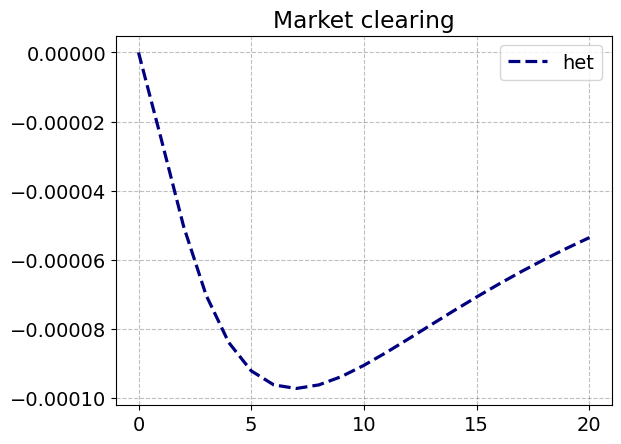

In [115]:
plt.plot(model_het.IRF['C_hh'][:21]-model_het.IRF['Y'][:21], label='het', linestyle='--', linewidth=2.3, color='navy')
plt.title('Market clearing')
plt.legend()
plt.show()

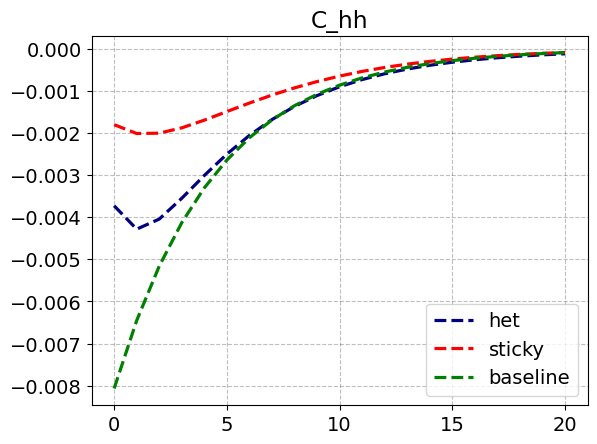

In [106]:
plt.plot(model_het.IRF['C_hh'][:21], label='het', linestyle='--', linewidth=2.3, color='navy')
plt.plot(model_sticky.IRF['C_hh'][:21], label='sticky', linestyle='--', linewidth=2.3, color='red')
plt.plot(model.IRF['C_hh'][:21], label='baseline', linestyle='--', linewidth=2.3, color='green')
plt.title('C_hh')
plt.legend()
plt.show()

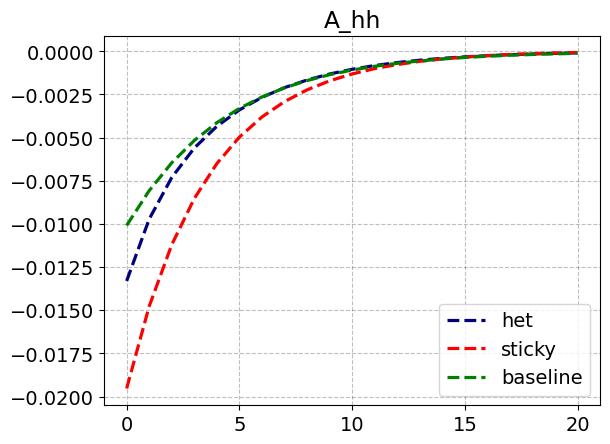

In [108]:
plt.plot(model_het.IRF['A_hh'][:21], label='het', linestyle='--', linewidth=2.3, color='navy')
plt.plot(model_sticky.IRF['A_hh'][:21], label='sticky', linestyle='--', linewidth=2.3, color='red')
plt.plot(model.IRF['A_hh'][:21], label='baseline', linestyle='--', linewidth=2.3, color='green')
plt.title('A_hh')
plt.legend()
plt.show()

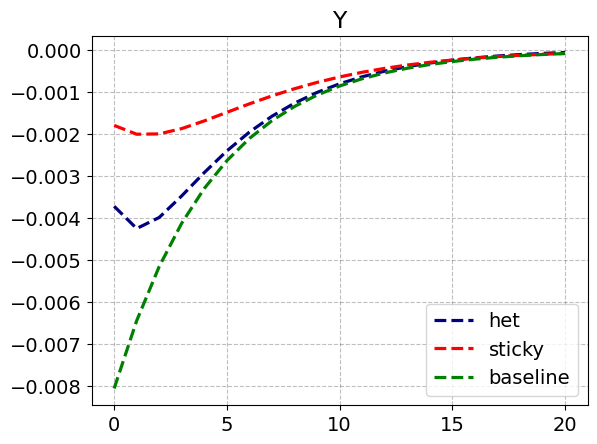

In [109]:
plt.plot(model_het.IRF['Y'][:21], label='het', linestyle='--', linewidth=2.3, color='navy')
plt.plot(model_sticky.IRF['Y'][:21], label='sticky', linestyle='--', linewidth=2.3, color='red')
plt.plot(model.IRF['Y'][:21], label='baseline', linestyle='--', linewidth=2.3, color='green')
plt.title('Y')
plt.legend()
plt.show()

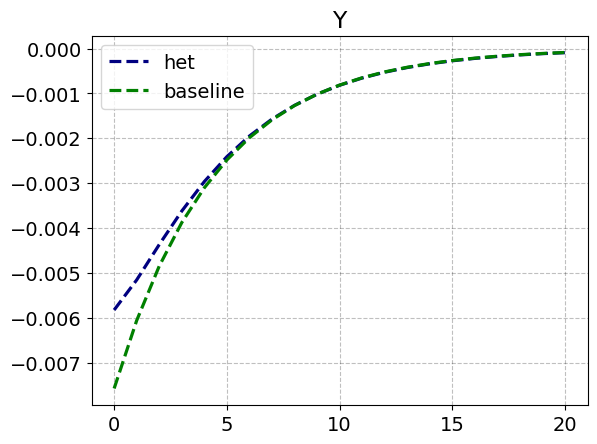

In [110]:
plt.plot(model_het.IRF['pi'][:21], label='het', linestyle='--', linewidth=2.3, color='navy')
#plt.plot(model_sticky.IRF['Y'][:21], label='sticky', linestyle='--', linewidth=2.3, color='red')
plt.plot(model.IRF['pi'][:21], label='baseline', linestyle='--', linewidth=2.3, color='green')
plt.title('Y')
plt.legend()
plt.show()

In [81]:
import numpy as np
import matplotlib.pyplot as plt

def decompose_C_by_z_and_input(model,
                               inputs=('Z', 'ra'),
                               output='C_hh',
                               T=None,
                               check_consistency=True):
    """
    Decompose the IRF of C_hh into contributions from each input, for each z.

    For each productivity state z, we compute:
        C_z_total(t)  = sum_i J_{C,z,i}(t,s) * IRF[input_i](s)
        C_z_from_inp(t) for inp in inputs

    Parameters
    ----------
    model : GE model object (e.g. model_het)
        Requires:
            model.jac_hh_z[(output, inp)] with shape (Nz, T, T)
            model.IRF[inp] with shape (T,)
            model.IRF[output] with shape (T,)  (for consistency check)
            model.ss.C_hh (steady state level of C_hh)
    inputs : tuple of str
        Inputs to include in the decomposition (default ('Z','ra')).
    output : str
        Household output variable (default 'C_hh').
    T : int or None
        Number of periods to use. If None, use full horizon implied by jacobians.
    check_consistency : bool
        If True, print diagnostic checks.

    Returns
    -------
    C_z_total_pct : np.ndarray, shape (Nz, T)
        Total C_hh^z(t) in percent deviation from steady state.
    C_z_contrib_pct : dict
        Keys are inputs, values are arrays (Nz, T) with percent deviations.
    """

    # 1. Infer Nz and T from one jacobian
    example_key = None
    for inp in inputs:
        key = (output, inp)
        if hasattr(model, 'jac_hh_z') and key in model.jac_hh_z:
            example_key = key
            break
    if example_key is None:
        raise KeyError(f"No per-z Jacobians found for {output} and inputs {inputs}.")

    J_example = model.jac_hh_z[example_key]  # (Nz, T, T)
    Nz, T_jac, _ = J_example.shape

    # Time horizon
    if T is None or T > T_jac:
        T = T_jac

    # 2. Build contributions in levels
    C_z_contrib = {}
    for inp in inputs:
        key = (output, inp)
        if key not in model.jac_hh_z:
            continue

        Jz = model.jac_hh_z[key]        # (Nz, T_jac, T_jac)
        x_irf = model.IRF[inp][:T_jac]  # (T,)

        Cz_inp = np.zeros((Nz, T_jac))
        for iz in range(Nz):
            Cz_inp[iz, :] = Jz[iz] @ x_irf

        C_z_contrib[inp] = Cz_inp[:, :T]  # trim to T

    # 3. Total per z = sum over included inputs
    C_z_total = np.zeros((Nz, T))
    for inp, Cz_inp in C_z_contrib.items():
        C_z_total += Cz_inp

    # 4. Consistency checks
    if check_consistency:

        # a) per-z: total vs sum of contributions
        for iz in range(Nz):
            # recompute sum contributions explicitly for that z
            sum_contrib_z = np.zeros(T)
            for inp in inputs:
                if inp in C_z_contrib:
                    sum_contrib_z += C_z_contrib[inp][iz, :]
            diff_z = C_z_total[iz, :] - sum_contrib_z
            print(f"[decomp] z={iz}: max|total - sum(contrib)| = {np.max(np.abs(diff_z)):.3e}")

        # b) aggregate across z vs model.IRF[output]
        if output in model.IRF:
            C_agg_from_z = C_z_total.sum(axis=0)
            C_agg_model  = model.IRF[output][:T]
            diff_agg = C_agg_from_z - C_agg_model
            print(f"[decomp] aggregate: max|Σ_z total - IRF[{output}]| = {np.max(np.abs(diff_agg)):.3e}")
        else:
            print(f"[decomp] Warning: {output} not in model.IRF, cannot check aggregate consistency.")

    # 5. Convert to percent deviation from steady state
    C_ss = model.ss.C_hh
    if C_ss == 0:
        raise ValueError("Steady-state C_hh is zero — cannot convert to percentages.")

    C_z_total_pct = 100 * C_z_total / C_ss
    C_z_contrib_pct = {inp: 100 * Cz / C_ss for inp, Cz in C_z_contrib.items()}

    return C_z_total_pct, C_z_contrib_pct


def plot_C_by_z_with_input_decomp(model,
                                  inputs=('Z','ra'),
                                  output='C_hh',
                                  T=None,
                                  title_prefix="C_hh IRF by z: total, from Z, from ra"):
    """
    Plot, for each productivity level z, the total C_hh IRF and
    contributions from each input in 'inputs', all in % deviation from SS.

    Returns
    -------
    C_z_total_pct, C_z_contrib_pct as from decompose_C_by_z_and_input.
    """

    C_z_total_pct, C_z_contrib_pct = decompose_C_by_z_and_input(
        model,
        inputs=inputs,
        output=output,
        T=T,
        check_consistency=True
    )

    Nz, T_eff = C_z_total_pct.shape
    t_grid = np.arange(T_eff)

    fig, axes = plt.subplots(Nz, 1, figsize=(7, 2.4 * Nz), sharex=True)
    if Nz == 1:
        axes = [axes]

    for iz in range(Nz):
        ax = axes[iz]

        # total
        ax.plot(t_grid, C_z_total_pct[iz, :], label='total', linewidth=2)

        # contributions from each input
        for inp in inputs:
            if inp in C_z_contrib_pct:
                ax.plot(t_grid, C_z_contrib_pct[inp][iz, :],
                        linestyle='--', linewidth=1.5, label=f'from {inp}')

        ax.axhline(0.0, linestyle=':', linewidth=0.7)
        ax.set_ylabel(f"z={iz}")
        ax.grid(True, alpha=0.3)

        # Put a legend only on first subplot to avoid clutter
        if iz == 0:
            ax.set_title(title_prefix)
            ax.legend(loc='best', fontsize=8)

    axes[-1].set_xlabel("t")
    plt.tight_layout()
    plt.show()

    return C_z_total_pct, C_z_contrib_pct


[decomp] z=0: max|total - sum(contrib)| = 0.000e+00
[decomp] z=1: max|total - sum(contrib)| = 0.000e+00
[decomp] z=2: max|total - sum(contrib)| = 0.000e+00
[decomp] z=3: max|total - sum(contrib)| = 0.000e+00
[decomp] z=4: max|total - sum(contrib)| = 0.000e+00
[decomp] z=5: max|total - sum(contrib)| = 0.000e+00
[decomp] aggregate: max|Σ_z total - IRF[C_hh]| = 3.832e-14


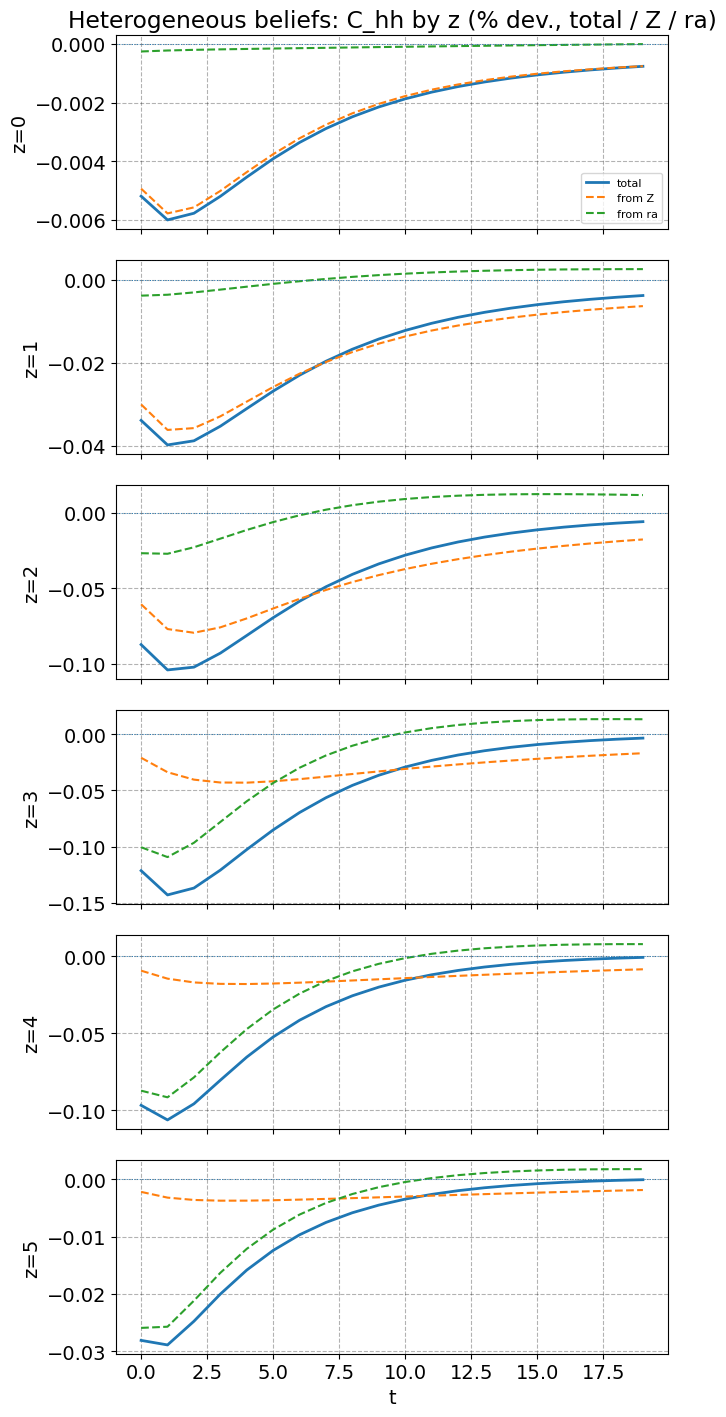

In [111]:
C_z_total_pct, C_z_contrib_pct = plot_C_by_z_with_input_decomp(
    model_het,
    inputs=('Z','ra'),
    output='C_hh',
    T=20,
    title_prefix="Heterogeneous beliefs: C_hh by z (% dev., total / Z / ra)"
)


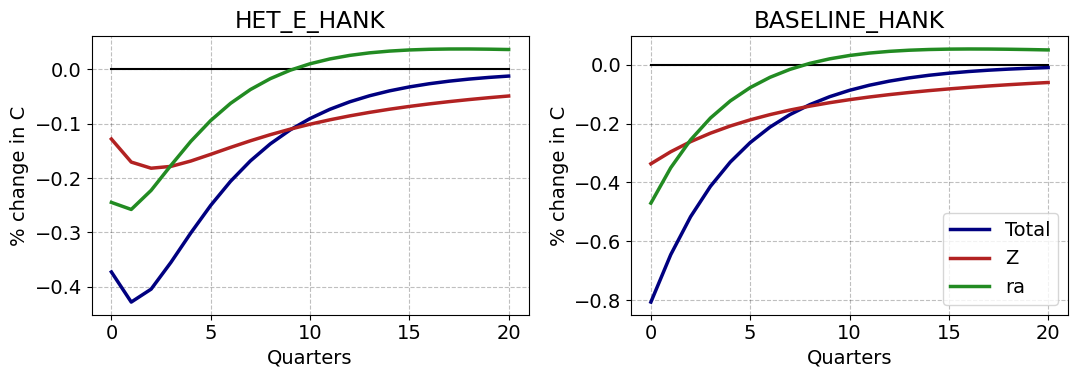

In [114]:
decomp(model,model_het, plot_test=False)

In [ ]:
import re, numpy as np
from collections import Counter

def _shape(x):
    return getattr(x, "shape", None)

def _is_sq_T(x, T=None):
    sh = _shape(x)
    return isinstance(sh, tuple) and len(sh)==2 and sh[0]==sh[1] and (T is None or sh[0]==T)

def _to_int_index(x):
    """Try to parse a z-index from ints or strings like 'z0', 'iz=3', 'state_5'."""
    if isinstance(x, (int, np.integer)): 
        return int(x)
    if isinstance(x, str):
        m = re.search(r'(-?\d+)', x)
        if m: 
            return int(m.group(1))
    return None

def _short(items, n=8):
    items = list(items)
    return items[:n] + (["..."] if len(items)>n else [])

def print_model_io_overview(model):
    # Pull T, Nz, and the input labels from your HH Jacobians
    if not hasattr(model, "jac_hh") or not model.jac_hh:
        print("model.jac_hh is missing or empty.")
        return None, None, []
    any_J = next(iter(model.jac_hh.values()))
    T = any_J.shape[0]
    Nz = int(getattr(model.par, "Nz", 0))
    inputs = sorted({k[1] for k in model.jac_hh.keys() if k[0] in ("C_hh","A_hh")})
    print(f"Model says: T={T}, Nz={Nz}, inputs={inputs}")
    return T, Nz, inputs

def peek_E_top(E):
    print(f"\nE_by_z_sane top-level type: {type(E).__name__}")
    if hasattr(E, "shape"):
        print(f"  ndarray shape: {E.shape}")
    elif isinstance(E, dict):
        keys = list(E.keys())
        print(f"  dict with {len(keys)} top-level keys. Sample: {_short(keys)}")
    elif isinstance(E, (list, tuple)):
        print(f"  {type(E).__name__} of length {len(E)}")

def analyze_E_dict(E, T=None, Nz=None, inputs=None, max_show=10):
    print("\n— Top-level dict analysis —")
    keys = list(E.keys())
    # 1) What kinds of keys?
    kinds = Counter(type(k).__name__ for k in keys)
    print("  key types:", dict(kinds))

    # 2) Tuple keys like (input, iz)
    tuple_keys = [k for k in keys if isinstance(k, tuple) and len(k)==2]
    if tuple_keys:
        print(f"  Found {len(tuple_keys)} tuple keys (input, iz). Sample:", _short(tuple_keys))
        # Parse tuples
        inputs_seen = []
        iz_seen = []
        bad_slices = 0
        for k in tuple_keys[:max_show]:
            I, z = k
            iz = _to_int_index(z)
            inputs_seen.append(str(I))
            iz_seen.append(iz)
            v = E[k]
            print(f"    {k!r}: value type={type(v).__name__}, shape={_shape(v)}")
            if T is not None and not _is_sq_T(v, T):
                bad_slices += 1
        print("  tuple inputs seen:", sorted(set(inputs_seen)))
        print("  tuple z parsed:", sorted(set(i for i in iz_seen if i is not None)))
        if bad_slices:
            print(f"  WARNING: {bad_slices} tuple entries are not (T,T)")

    # 3) String keys that might be input names
    str_keys = [k for k in keys if isinstance(k, str)]
    if str_keys:
        print(f"\n  Found {len(str_keys)} string keys. Sample:", _short(str_keys))
        # For each string key, look at value shape/type
        for k in str_keys[:max_show]:
            v = E[k]
            print(f"    '{k}': type={type(v).__name__}, shape={_shape(v)}")
            if isinstance(v, dict):
                subk = list(v.keys())
                print(f"      nested dict with {len(subk)} keys. Sample:", _short(subk))
                # Try parse iz from nested keys
                izs = [_to_int_index(sk) for sk in subk]
                izs = [i for i in izs if i is not None]
                if izs:
                    print(f"      parsed nested z-indices:", sorted(set(izs)))
                # Check shapes of first few
                for sk in _short(subk, n=5):
                    vv = v[sk]
                    print(f"        subkey {sk!r}: type={type(vv).__name__}, shape={_shape(vv)}")
            elif hasattr(v, "shape") and len(v.shape)==3:
                print("      3D array under this key → likely per-z block (Nz,T,T) or (T,T,Nz).")
            elif isinstance(v, (list, tuple)):
                print(f"      list/tuple len={len(v)}; first item shape={_shape(v[0]) if v else None}")

    # 4) Int-like keys (top-level dict[iz] case)
    intlike = [k for k in keys if _to_int_index(k) is not None]
    if intlike:
        print(f"\n  Found {len(intlike)} int-like keys at top-level (e.g., per-z). Sample:", _short(intlike))
        for k in intlike[:max_show]:
            v = E[k]
            print(f"    key {k!r}: type={type(v).__name__}, shape={_shape(v)}")
            if isinstance(v, dict):
                print("      nested dict under a z-key (unusual).")
            if hasattr(v, "shape") and len(v.shape)==3:
                print("      3D array under a z-key → likely per-z block holding many z.")

def analyze_E_array(A, T=None, Nz=None):
    sh = getattr(A, "shape", None)
    print("\n— Array analysis —")
    print("  shape:", sh)
    if sh is None:
        print("  Not an array.")
        return
    if len(sh)==2:
        print("  Looks like a single (T,T) operator for all z and inputs.")
    elif len(sh)==3:
        if Nz is not None and sh[0]==Nz and sh[1]==sh[2]:
            print("  Looks like (Nz, T, T): per-z operator for all inputs.")
        elif Nz is not None and sh[-1]==Nz and sh[0]==sh[1]:
            print("  Looks like (T, T, Nz): per-z operator for all inputs.")
        else:
            print("  3D but cannot infer axes from Nz/T—will need explicit mapping.")
    else:
        print("  Unexpected ndim; please share.")

def overview_E_by_z_sane(E_by_z_sane, model):
    print("=== MODEL IO OVERVIEW ===")
    T, Nz, inputs = print_model_io_overview(model)
    print("\n=== E_by_z_sane OVERVIEW ===")
    peek_E_top(E_by_z_sane)
    if isinstance(E_by_z_sane, dict):
        analyze_E_dict(E_by_z_sane, T=T, Nz=Nz, inputs=inputs)
    elif hasattr(E_by_z_sane, "shape"):
        analyze_E_array(E_by_z_sane, T=T, Nz=Nz)
    elif isinstance(E_by_z_sane, (list, tuple)):
        print("\n— Top-level list/tuple —")
        L = E_by_z_sane
        print("  len:", len(L))
        if len(L)>0:
            print("  first item type:", type(L[0]).__name__, "shape:", _shape(L[0]))
            if hasattr(L[0], "shape") and len(L[0].shape)==2:
                print("  Looks like per-z list/tuple of (T,T).")
            elif hasattr(L[0], "shape") and len(L[0].shape)==3:
                print("  Nested 3D under list—please share.")
    else:
        print("E_by_z_sane is of unsupported type; please share its structure.")

# ---- Run this ----
overview_E_by_z_sane(E_by_z_sane, model)


In [ ]:
model_het.compute_jacs(skip_hh=True,skip_shocks=False)
model_het.find_IRFs(shocks=['eps_i'],do_print=False)

In [ ]:
plt.plot(model_het.IRF['C_hh'][:21], label='het', linestyle='--', linewidth=2.3, color='navy')
plt.plot(model_sticky.IRF['C_hh'][:21], label='sticky', linestyle='--', linewidth=2.3, color='red')
plt.plot(model.IRF['C_hh'][:21], label='baseline', linestyle='--', linewidth=2.3, color='green')
plt.title('C_hh')
plt.legend()
plt.show()

In [ ]:
plt.plot(model_het.IRF['A_hh'][:21], label='het', linestyle='--', linewidth=2.3, color='navy')
#plt.plot(model_sticky.IRF['C_hh'][:21], label='sticky', linestyle='--', linewidth=2.3, color='red')
plt.plot(model.IRF['A_hh'][:21], label='baseline', linestyle='--', linewidth=2.3, color='green')
plt.title('A_hh')
plt.legend()
plt.show()

In [ ]:
plt.plot(model_het.IRF['C_hh'][:21]-model_het.IRF['Y'][:21], label='het', linestyle='--', linewidth=2.3, color='navy')
plt.title('C_hh')
plt.legend()
plt.show()